## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import *

device = "cpu"
if torch.cuda.is_available():
    print("GPU is available")
    device = "cuda:0"
net = Net2()
print("device: ", device)
print(net)

GPU is available
device:  cuda:0
Net2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=73728, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [7]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        net.to(device) # move to GPU when available 
        output_pts = net(images.to(device))
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

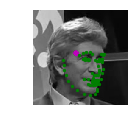

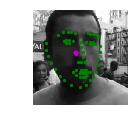

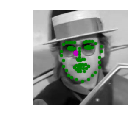

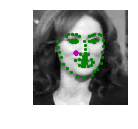

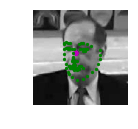

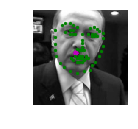

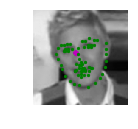

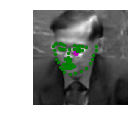

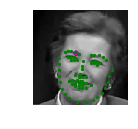

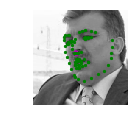

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

#optimizer = optim.SGD(net.parameters(), lr=0.05)
optimizer = optim.Adam(net.parameters(), lr=0.00005, betas=(0.9, 0.999))
# lr=0.0001, epochs=100 model2: keypoints_model_2.pt
# lr=0.0005, epochs=300 model2: keypoints_model_2.1.pt
# lr=0.0005, epochs=600 model2: keypoints_model_2.2.pt

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            net.to(device) # move to GPU when available
            output_pts = net(images.to(device))

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts.to(device))

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [14]:
# train your network
n_epochs = 600 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.004880302220582962
Epoch: 1, Batch: 20, Avg. Loss: 0.002389975368976593
Epoch: 1, Batch: 30, Avg. Loss: 0.0019083579778671265
Epoch: 1, Batch: 40, Avg. Loss: 0.0021481980681419374
Epoch: 1, Batch: 50, Avg. Loss: 0.002403313934803009
Epoch: 1, Batch: 60, Avg. Loss: 0.002641821473836899
Epoch: 1, Batch: 70, Avg. Loss: 0.0021501474231481552
Epoch: 1, Batch: 80, Avg. Loss: 0.0018036552369594574
Epoch: 1, Batch: 90, Avg. Loss: 0.0020908962488174437
Epoch: 1, Batch: 100, Avg. Loss: 0.0019012698903679848
Epoch: 1, Batch: 110, Avg. Loss: 0.001761837974190712
Epoch: 1, Batch: 120, Avg. Loss: 0.0019013473689556122
Epoch: 1, Batch: 130, Avg. Loss: 0.0018116124868392943
Epoch: 1, Batch: 140, Avg. Loss: 0.001933312237262726
Epoch: 1, Batch: 150, Avg. Loss: 0.002250073730945587
Epoch: 1, Batch: 160, Avg. Loss: 0.0017739418298006058
Epoch: 1, Batch: 170, Avg. Loss: 0.0018046024516224861
Epoch: 1, Batch: 180, Avg. Loss: 0.0017597533389925957
Epoch: 1, Batch: 190, Avg.

Epoch: 8, Batch: 60, Avg. Loss: 0.0014099164232611657
Epoch: 8, Batch: 70, Avg. Loss: 0.0016039528027176858
Epoch: 8, Batch: 80, Avg. Loss: 0.0016023491695523263
Epoch: 8, Batch: 90, Avg. Loss: 0.0015792791545391083
Epoch: 8, Batch: 100, Avg. Loss: 0.0014650197327136993
Epoch: 8, Batch: 110, Avg. Loss: 0.0016681446805596352
Epoch: 8, Batch: 120, Avg. Loss: 0.0012855774462223054
Epoch: 8, Batch: 130, Avg. Loss: 0.0020036075711250306
Epoch: 8, Batch: 140, Avg. Loss: 0.0015537098944187165
Epoch: 8, Batch: 150, Avg. Loss: 0.0013775819092988967
Epoch: 8, Batch: 160, Avg. Loss: 0.0014701581224799156
Epoch: 8, Batch: 170, Avg. Loss: 0.001287504866719246
Epoch: 8, Batch: 180, Avg. Loss: 0.0016052499711513518
Epoch: 8, Batch: 190, Avg. Loss: 0.0016070271730422973
Epoch: 8, Batch: 200, Avg. Loss: 0.0012036897093057632
Epoch: 8, Batch: 210, Avg. Loss: 0.0014029642790555955
Epoch: 9, Batch: 10, Avg. Loss: 0.0014599150642752648
Epoch: 9, Batch: 20, Avg. Loss: 0.0015946534276008607
Epoch: 9, Batch: 

Epoch: 15, Batch: 80, Avg. Loss: 0.001242337055504322
Epoch: 15, Batch: 90, Avg. Loss: 0.001624349318444729
Epoch: 15, Batch: 100, Avg. Loss: 0.0012791833877563476
Epoch: 15, Batch: 110, Avg. Loss: 0.0015747380927205086
Epoch: 15, Batch: 120, Avg. Loss: 0.0012750039249658585
Epoch: 15, Batch: 130, Avg. Loss: 0.0013972650840878486
Epoch: 15, Batch: 140, Avg. Loss: 0.0011058373153209687
Epoch: 15, Batch: 150, Avg. Loss: 0.0017877256125211716
Epoch: 15, Batch: 160, Avg. Loss: 0.0011000393405556678
Epoch: 15, Batch: 170, Avg. Loss: 0.0012470154315233231
Epoch: 15, Batch: 180, Avg. Loss: 0.0014688761010766029
Epoch: 15, Batch: 190, Avg. Loss: 0.0015089947432279586
Epoch: 15, Batch: 200, Avg. Loss: 0.0013209740743041038
Epoch: 15, Batch: 210, Avg. Loss: 0.001232306569814682
Epoch: 16, Batch: 10, Avg. Loss: 0.0011476271227002144
Epoch: 16, Batch: 20, Avg. Loss: 0.0018108972758054734
Epoch: 16, Batch: 30, Avg. Loss: 0.0015655216053128242
Epoch: 16, Batch: 40, Avg. Loss: 0.0012132546380162238
E

Epoch: 22, Batch: 100, Avg. Loss: 0.0018581073470413684
Epoch: 22, Batch: 110, Avg. Loss: 0.0011255919560790061
Epoch: 22, Batch: 120, Avg. Loss: 0.0007920056059956551
Epoch: 22, Batch: 130, Avg. Loss: 0.0010229610018432141
Epoch: 22, Batch: 140, Avg. Loss: 0.0010386824049055576
Epoch: 22, Batch: 150, Avg. Loss: 0.0011607392393052577
Epoch: 22, Batch: 160, Avg. Loss: 0.0009293888583779335
Epoch: 22, Batch: 170, Avg. Loss: 0.0007453036084771156
Epoch: 22, Batch: 180, Avg. Loss: 0.0013305744044482708
Epoch: 22, Batch: 190, Avg. Loss: 0.00085631899908185
Epoch: 22, Batch: 200, Avg. Loss: 0.0008506974689662457
Epoch: 22, Batch: 210, Avg. Loss: 0.000857013262808323
Epoch: 23, Batch: 10, Avg. Loss: 0.000828212533146143
Epoch: 23, Batch: 20, Avg. Loss: 0.0010278757438063621
Epoch: 23, Batch: 30, Avg. Loss: 0.0010122522935271264
Epoch: 23, Batch: 40, Avg. Loss: 0.0007856419943273067
Epoch: 23, Batch: 50, Avg. Loss: 0.0009124364107847214
Epoch: 23, Batch: 60, Avg. Loss: 0.0011254031993448734
Ep

Epoch: 29, Batch: 110, Avg. Loss: 0.0016917143985629081
Epoch: 29, Batch: 120, Avg. Loss: 0.0006741719618439674
Epoch: 29, Batch: 130, Avg. Loss: 0.0008227741904556752
Epoch: 29, Batch: 140, Avg. Loss: 0.0006746096722781658
Epoch: 29, Batch: 150, Avg. Loss: 0.0006926378645002841
Epoch: 29, Batch: 160, Avg. Loss: 0.0005723578166216611
Epoch: 29, Batch: 170, Avg. Loss: 0.0009415702931582928
Epoch: 29, Batch: 180, Avg. Loss: 0.0006587703898549079
Epoch: 29, Batch: 190, Avg. Loss: 0.0007492099739611149
Epoch: 29, Batch: 200, Avg. Loss: 0.0006434989124536514
Epoch: 29, Batch: 210, Avg. Loss: 0.0008505029827356338
Epoch: 30, Batch: 10, Avg. Loss: 0.0004478450305759907
Epoch: 30, Batch: 20, Avg. Loss: 0.0007381028272211552
Epoch: 30, Batch: 30, Avg. Loss: 0.0007976655587553978
Epoch: 30, Batch: 40, Avg. Loss: 0.0006978591866791249
Epoch: 30, Batch: 50, Avg. Loss: 0.0007313900142908096
Epoch: 30, Batch: 60, Avg. Loss: 0.0007991567589342594
Epoch: 30, Batch: 70, Avg. Loss: 0.0006801932640373707

Epoch: 36, Batch: 120, Avg. Loss: 0.0005433177761733532
Epoch: 36, Batch: 130, Avg. Loss: 0.000717425785958767
Epoch: 36, Batch: 140, Avg. Loss: 0.0005525189470499754
Epoch: 36, Batch: 150, Avg. Loss: 0.0004969944823533296
Epoch: 36, Batch: 160, Avg. Loss: 0.000958758033812046
Epoch: 36, Batch: 170, Avg. Loss: 0.0005053912550210953
Epoch: 36, Batch: 180, Avg. Loss: 0.0008555823490023613
Epoch: 36, Batch: 190, Avg. Loss: 0.0005206669550389052
Epoch: 36, Batch: 200, Avg. Loss: 0.0013389424439519645
Epoch: 36, Batch: 210, Avg. Loss: 0.0005841796584427357
Epoch: 37, Batch: 10, Avg. Loss: 0.0006976643241941928
Epoch: 37, Batch: 20, Avg. Loss: 0.0008168610706925392
Epoch: 37, Batch: 30, Avg. Loss: 0.0004957372099161148
Epoch: 37, Batch: 40, Avg. Loss: 0.000806113937869668
Epoch: 37, Batch: 50, Avg. Loss: 0.0004158708229660988
Epoch: 37, Batch: 60, Avg. Loss: 0.0004092436023056507
Epoch: 37, Batch: 70, Avg. Loss: 0.0005285192020237446
Epoch: 37, Batch: 80, Avg. Loss: 0.0005649245269596576
Epo

Epoch: 43, Batch: 130, Avg. Loss: 0.00041031858511269095
Epoch: 43, Batch: 140, Avg. Loss: 0.00042284022457897663
Epoch: 43, Batch: 150, Avg. Loss: 0.0004962967820465564
Epoch: 43, Batch: 160, Avg. Loss: 0.0011311421245336533
Epoch: 43, Batch: 170, Avg. Loss: 0.0004708997365087271
Epoch: 43, Batch: 180, Avg. Loss: 0.0004935399107635021
Epoch: 43, Batch: 190, Avg. Loss: 0.0011792180351912975
Epoch: 43, Batch: 200, Avg. Loss: 0.00045504607632756235
Epoch: 43, Batch: 210, Avg. Loss: 0.0004948988892138005
Epoch: 44, Batch: 10, Avg. Loss: 0.0005262993052601814
Epoch: 44, Batch: 20, Avg. Loss: 0.00039171553216874597
Epoch: 44, Batch: 30, Avg. Loss: 0.0005308539420366287
Epoch: 44, Batch: 40, Avg. Loss: 0.0009063032884150744
Epoch: 44, Batch: 50, Avg. Loss: 0.000511840783059597
Epoch: 44, Batch: 60, Avg. Loss: 0.000498092845082283
Epoch: 44, Batch: 70, Avg. Loss: 0.0005996265392750502
Epoch: 44, Batch: 80, Avg. Loss: 0.0009567581191658974
Epoch: 44, Batch: 90, Avg. Loss: 0.0007008836045861245

Epoch: 50, Batch: 140, Avg. Loss: 0.0004765417166054249
Epoch: 50, Batch: 150, Avg. Loss: 0.0005443116165697575
Epoch: 50, Batch: 160, Avg. Loss: 0.00034484649635851386
Epoch: 50, Batch: 170, Avg. Loss: 0.0004414203502237797
Epoch: 50, Batch: 180, Avg. Loss: 0.0006294116713106633
Epoch: 50, Batch: 190, Avg. Loss: 0.00048366970382630826
Epoch: 50, Batch: 200, Avg. Loss: 0.00044047654047608373
Epoch: 50, Batch: 210, Avg. Loss: 0.0003743968028575182
Epoch: 51, Batch: 10, Avg. Loss: 0.0014150370806455613
Epoch: 51, Batch: 20, Avg. Loss: 0.00046535131521523
Epoch: 51, Batch: 30, Avg. Loss: 0.00041587414406239986
Epoch: 51, Batch: 40, Avg. Loss: 0.0004834151789546013
Epoch: 51, Batch: 50, Avg. Loss: 0.00040610541589558124
Epoch: 51, Batch: 60, Avg. Loss: 0.0004475858844816685
Epoch: 51, Batch: 70, Avg. Loss: 0.0006727335043251514
Epoch: 51, Batch: 80, Avg. Loss: 0.0004696725178509951
Epoch: 51, Batch: 90, Avg. Loss: 0.0004372012037783861
Epoch: 51, Batch: 100, Avg. Loss: 0.000412344022653996

Epoch: 57, Batch: 140, Avg. Loss: 0.00036810557823628185
Epoch: 57, Batch: 150, Avg. Loss: 0.00034455928951501844
Epoch: 57, Batch: 160, Avg. Loss: 0.000365764208137989
Epoch: 57, Batch: 170, Avg. Loss: 0.0003724471256136894
Epoch: 57, Batch: 180, Avg. Loss: 0.00030983395129442217
Epoch: 57, Batch: 190, Avg. Loss: 0.00033056609332561494
Epoch: 57, Batch: 200, Avg. Loss: 0.000345312362536788
Epoch: 57, Batch: 210, Avg. Loss: 0.00035169051960110665
Epoch: 58, Batch: 10, Avg. Loss: 0.0003727449141442776
Epoch: 58, Batch: 20, Avg. Loss: 0.0002776388246566057
Epoch: 58, Batch: 30, Avg. Loss: 0.00033316178619861603
Epoch: 58, Batch: 40, Avg. Loss: 0.00044835007563233376
Epoch: 58, Batch: 50, Avg. Loss: 0.00037862854450941086
Epoch: 58, Batch: 60, Avg. Loss: 0.00032060338370501994
Epoch: 58, Batch: 70, Avg. Loss: 0.00035644777864217756
Epoch: 58, Batch: 80, Avg. Loss: 0.00038424581848084925
Epoch: 58, Batch: 90, Avg. Loss: 0.0007421499285846948
Epoch: 58, Batch: 100, Avg. Loss: 0.000389909207

Epoch: 64, Batch: 140, Avg. Loss: 0.0003366586212068796
Epoch: 64, Batch: 150, Avg. Loss: 0.0005209451094269753
Epoch: 64, Batch: 160, Avg. Loss: 0.0004365521911531687
Epoch: 64, Batch: 170, Avg. Loss: 0.00045402051974087953
Epoch: 64, Batch: 180, Avg. Loss: 0.0006233498379588127
Epoch: 64, Batch: 190, Avg. Loss: 0.00041794932633638384
Epoch: 64, Batch: 200, Avg. Loss: 0.00028876144997775553
Epoch: 64, Batch: 210, Avg. Loss: 0.0003078639134764671
Epoch: 65, Batch: 10, Avg. Loss: 0.00043767239712178707
Epoch: 65, Batch: 20, Avg. Loss: 0.00030069755762815475
Epoch: 65, Batch: 30, Avg. Loss: 0.0002834842447191477
Epoch: 65, Batch: 40, Avg. Loss: 0.0004236839022487402
Epoch: 65, Batch: 50, Avg. Loss: 0.00033221697807312014
Epoch: 65, Batch: 60, Avg. Loss: 0.00044706230238080027
Epoch: 65, Batch: 70, Avg. Loss: 0.00034450019709765913
Epoch: 65, Batch: 80, Avg. Loss: 0.00041949470341205594
Epoch: 65, Batch: 90, Avg. Loss: 0.00035363610647618773
Epoch: 65, Batch: 100, Avg. Loss: 0.00032401420

Epoch: 71, Batch: 140, Avg. Loss: 0.0003810589089989662
Epoch: 71, Batch: 150, Avg. Loss: 0.0003756474293768406
Epoch: 71, Batch: 160, Avg. Loss: 0.0004135203016921878
Epoch: 71, Batch: 170, Avg. Loss: 0.0003783255890011787
Epoch: 71, Batch: 180, Avg. Loss: 0.00035120821930468085
Epoch: 71, Batch: 190, Avg. Loss: 0.00034552408196032047
Epoch: 71, Batch: 200, Avg. Loss: 0.00025251539796590803
Epoch: 71, Batch: 210, Avg. Loss: 0.00032009475491940974
Epoch: 72, Batch: 10, Avg. Loss: 0.00024697253666818144
Epoch: 72, Batch: 20, Avg. Loss: 0.00031579098012298346
Epoch: 72, Batch: 30, Avg. Loss: 0.0011622024653479457
Epoch: 72, Batch: 40, Avg. Loss: 0.00029820046201348307
Epoch: 72, Batch: 50, Avg. Loss: 0.0002865182012319565
Epoch: 72, Batch: 60, Avg. Loss: 0.0005557817276567221
Epoch: 72, Batch: 70, Avg. Loss: 0.0004279369879513979
Epoch: 72, Batch: 80, Avg. Loss: 0.00023649336397647857
Epoch: 72, Batch: 90, Avg. Loss: 0.0007128880955278873
Epoch: 72, Batch: 100, Avg. Loss: 0.0005388427954

Epoch: 78, Batch: 140, Avg. Loss: 0.0002493134196847677
Epoch: 78, Batch: 150, Avg. Loss: 0.00025982302706688645
Epoch: 78, Batch: 160, Avg. Loss: 0.00027314464841037987
Epoch: 78, Batch: 170, Avg. Loss: 0.0005601877281442285
Epoch: 78, Batch: 180, Avg. Loss: 0.00039401536993682385
Epoch: 78, Batch: 190, Avg. Loss: 0.0003952945629134774
Epoch: 78, Batch: 200, Avg. Loss: 0.0002637113621458411
Epoch: 78, Batch: 210, Avg. Loss: 0.00038236233592033384
Epoch: 79, Batch: 10, Avg. Loss: 0.0003357561668381095
Epoch: 79, Batch: 20, Avg. Loss: 0.0003546138033270836
Epoch: 79, Batch: 30, Avg. Loss: 0.0004677272643893957
Epoch: 79, Batch: 40, Avg. Loss: 0.00025664369761943816
Epoch: 79, Batch: 50, Avg. Loss: 0.00039876990206539633
Epoch: 79, Batch: 60, Avg. Loss: 0.00036969882808625696
Epoch: 79, Batch: 70, Avg. Loss: 0.00031486351694911716
Epoch: 79, Batch: 80, Avg. Loss: 0.0003370692580938339
Epoch: 79, Batch: 90, Avg. Loss: 0.00020940288435667754
Epoch: 79, Batch: 100, Avg. Loss: 0.000281669424

Epoch: 85, Batch: 140, Avg. Loss: 0.0002789443489164114
Epoch: 85, Batch: 150, Avg. Loss: 0.0002505474919453263
Epoch: 85, Batch: 160, Avg. Loss: 0.0002409727396443486
Epoch: 85, Batch: 170, Avg. Loss: 0.0003737332671880722
Epoch: 85, Batch: 180, Avg. Loss: 0.0003019322156906128
Epoch: 85, Batch: 190, Avg. Loss: 0.00026121337711811066
Epoch: 85, Batch: 200, Avg. Loss: 0.00027128363773226737
Epoch: 85, Batch: 210, Avg. Loss: 0.0007477266564965248
Epoch: 86, Batch: 10, Avg. Loss: 0.0003431093692779541
Epoch: 86, Batch: 20, Avg. Loss: 0.000505562612786889
Epoch: 86, Batch: 30, Avg. Loss: 0.0003142285980284214
Epoch: 86, Batch: 40, Avg. Loss: 0.00028766122460365293
Epoch: 86, Batch: 50, Avg. Loss: 0.00029946558456867933
Epoch: 86, Batch: 60, Avg. Loss: 0.0005512222740799189
Epoch: 86, Batch: 70, Avg. Loss: 0.0003033737912774086
Epoch: 86, Batch: 80, Avg. Loss: 0.0003157106675207615
Epoch: 86, Batch: 90, Avg. Loss: 0.0003571479581296444
Epoch: 86, Batch: 100, Avg. Loss: 0.000285871824249625

Epoch: 92, Batch: 140, Avg. Loss: 0.00022300486266613005
Epoch: 92, Batch: 150, Avg. Loss: 0.0008206168171018362
Epoch: 92, Batch: 160, Avg. Loss: 0.00022522306069731714
Epoch: 92, Batch: 170, Avg. Loss: 0.0002661114996299148
Epoch: 92, Batch: 180, Avg. Loss: 0.0002218722803518176
Epoch: 92, Batch: 190, Avg. Loss: 0.00027508034743368623
Epoch: 92, Batch: 200, Avg. Loss: 0.00023553572688251733
Epoch: 92, Batch: 210, Avg. Loss: 0.0011276746476069092
Epoch: 93, Batch: 10, Avg. Loss: 0.0005283051123842597
Epoch: 93, Batch: 20, Avg. Loss: 0.00029644092824310063
Epoch: 93, Batch: 30, Avg. Loss: 0.00020579003170132637
Epoch: 93, Batch: 40, Avg. Loss: 0.00022416199464350938
Epoch: 93, Batch: 50, Avg. Loss: 0.0003877911884337664
Epoch: 93, Batch: 60, Avg. Loss: 0.0003477655742317438
Epoch: 93, Batch: 70, Avg. Loss: 0.0002677767677232623
Epoch: 93, Batch: 80, Avg. Loss: 0.0002704929243773222
Epoch: 93, Batch: 90, Avg. Loss: 0.0003408157639205456
Epoch: 93, Batch: 100, Avg. Loss: 0.00020863667596

Epoch: 99, Batch: 140, Avg. Loss: 0.0002964377403259277
Epoch: 99, Batch: 150, Avg. Loss: 0.00025408598966896535
Epoch: 99, Batch: 160, Avg. Loss: 0.00023108763061463833
Epoch: 99, Batch: 170, Avg. Loss: 0.00020453914441168308
Epoch: 99, Batch: 180, Avg. Loss: 0.00026319524459540847
Epoch: 99, Batch: 190, Avg. Loss: 0.0004505896298214793
Epoch: 99, Batch: 200, Avg. Loss: 0.0002595152901485562
Epoch: 99, Batch: 210, Avg. Loss: 0.00027130921185016633
Epoch: 100, Batch: 10, Avg. Loss: 0.0001871611773967743
Epoch: 100, Batch: 20, Avg. Loss: 0.0001926342137157917
Epoch: 100, Batch: 30, Avg. Loss: 0.00020707578863948583
Epoch: 100, Batch: 40, Avg. Loss: 0.00023759636376053094
Epoch: 100, Batch: 50, Avg. Loss: 0.00022069041803479195
Epoch: 100, Batch: 60, Avg. Loss: 0.00023186895903199912
Epoch: 100, Batch: 70, Avg. Loss: 0.0013593319337815047
Epoch: 100, Batch: 80, Avg. Loss: 0.0002449994906783104
Epoch: 100, Batch: 90, Avg. Loss: 0.00032400823291391133
Epoch: 100, Batch: 100, Avg. Loss: 0.0

Epoch: 106, Batch: 110, Avg. Loss: 0.00023808040842413902
Epoch: 106, Batch: 120, Avg. Loss: 0.00019631909020245076
Epoch: 106, Batch: 130, Avg. Loss: 0.0005302915647625923
Epoch: 106, Batch: 140, Avg. Loss: 0.0008935333080589772
Epoch: 106, Batch: 150, Avg. Loss: 0.00021481104101985692
Epoch: 106, Batch: 160, Avg. Loss: 0.00020075317285954953
Epoch: 106, Batch: 170, Avg. Loss: 0.00023416899424046278
Epoch: 106, Batch: 180, Avg. Loss: 0.00020487803500145673
Epoch: 106, Batch: 190, Avg. Loss: 0.00025686450488865377
Epoch: 106, Batch: 200, Avg. Loss: 0.0002089361362159252
Epoch: 106, Batch: 210, Avg. Loss: 0.0003373867915943265
Epoch: 107, Batch: 10, Avg. Loss: 0.00024329049699008465
Epoch: 107, Batch: 20, Avg. Loss: 0.00026400071755051615
Epoch: 107, Batch: 30, Avg. Loss: 0.0003516285168007016
Epoch: 107, Batch: 40, Avg. Loss: 0.00021870635449886322
Epoch: 107, Batch: 50, Avg. Loss: 0.0002665345435962081
Epoch: 107, Batch: 60, Avg. Loss: 0.0006158570917323232
Epoch: 107, Batch: 70, Avg.

Epoch: 113, Batch: 80, Avg. Loss: 0.00015801655687391758
Epoch: 113, Batch: 90, Avg. Loss: 0.0003360791215673089
Epoch: 113, Batch: 100, Avg. Loss: 0.0003005940243601799
Epoch: 113, Batch: 110, Avg. Loss: 0.0002723933272063732
Epoch: 113, Batch: 120, Avg. Loss: 0.00022582811675965787
Epoch: 113, Batch: 130, Avg. Loss: 0.00022683609370142223
Epoch: 113, Batch: 140, Avg. Loss: 0.0002612274019047618
Epoch: 113, Batch: 150, Avg. Loss: 0.000361748730763793
Epoch: 113, Batch: 160, Avg. Loss: 0.00021126205008476973
Epoch: 113, Batch: 170, Avg. Loss: 0.00040208632312715054
Epoch: 113, Batch: 180, Avg. Loss: 0.0003683286141604185
Epoch: 113, Batch: 190, Avg. Loss: 0.00024076341837644578
Epoch: 113, Batch: 200, Avg. Loss: 0.00019591827783733607
Epoch: 113, Batch: 210, Avg. Loss: 0.0002829948468133807
Epoch: 114, Batch: 10, Avg. Loss: 0.00022747380658984186
Epoch: 114, Batch: 20, Avg. Loss: 0.00017003217432647944
Epoch: 114, Batch: 30, Avg. Loss: 0.00020496668200939894
Epoch: 114, Batch: 40, Avg.

Epoch: 120, Batch: 50, Avg. Loss: 0.0002653180230408907
Epoch: 120, Batch: 60, Avg. Loss: 0.00039809395279735325
Epoch: 120, Batch: 70, Avg. Loss: 0.00024368744716048242
Epoch: 120, Batch: 80, Avg. Loss: 0.00023334174137562514
Epoch: 120, Batch: 90, Avg. Loss: 0.00019310307595878838
Epoch: 120, Batch: 100, Avg. Loss: 0.00024065461196005344
Epoch: 120, Batch: 110, Avg. Loss: 0.00017374390549957752
Epoch: 120, Batch: 120, Avg. Loss: 0.00021837686095386744
Epoch: 120, Batch: 130, Avg. Loss: 0.00017777018342167138
Epoch: 120, Batch: 140, Avg. Loss: 0.00020480239111930133
Epoch: 120, Batch: 150, Avg. Loss: 0.00021622628904879092
Epoch: 120, Batch: 160, Avg. Loss: 0.00017875928059220313
Epoch: 120, Batch: 170, Avg. Loss: 0.0001779540041461587
Epoch: 120, Batch: 180, Avg. Loss: 0.00032187847420573235
Epoch: 120, Batch: 190, Avg. Loss: 0.00021241824980825185
Epoch: 120, Batch: 200, Avg. Loss: 0.00022482335194945336
Epoch: 120, Batch: 210, Avg. Loss: 0.00020836770161986352
Epoch: 121, Batch: 10

Epoch: 127, Batch: 20, Avg. Loss: 0.00045400607492774724
Epoch: 127, Batch: 30, Avg. Loss: 0.0001567278876900673
Epoch: 127, Batch: 40, Avg. Loss: 0.00036224670708179474
Epoch: 127, Batch: 50, Avg. Loss: 0.00014409380778670312
Epoch: 127, Batch: 60, Avg. Loss: 0.00015093819238245487
Epoch: 127, Batch: 70, Avg. Loss: 0.00022620450239628552
Epoch: 127, Batch: 80, Avg. Loss: 0.00015812374465167523
Epoch: 127, Batch: 90, Avg. Loss: 0.00017549972143024206
Epoch: 127, Batch: 100, Avg. Loss: 0.00018965524341911077
Epoch: 127, Batch: 110, Avg. Loss: 0.00034947850368916987
Epoch: 127, Batch: 120, Avg. Loss: 0.00023732172697782516
Epoch: 127, Batch: 130, Avg. Loss: 0.0005629367884248495
Epoch: 127, Batch: 140, Avg. Loss: 0.00016214236337691547
Epoch: 127, Batch: 150, Avg. Loss: 0.00016542472597211598
Epoch: 127, Batch: 160, Avg. Loss: 0.00018825117498636246
Epoch: 127, Batch: 170, Avg. Loss: 0.0001891317656263709
Epoch: 127, Batch: 180, Avg. Loss: 0.00016755473800003528
Epoch: 127, Batch: 190, A

Epoch: 133, Batch: 200, Avg. Loss: 0.00022686980944126845
Epoch: 133, Batch: 210, Avg. Loss: 0.0008947673020884394
Epoch: 134, Batch: 10, Avg. Loss: 0.0001895114229992032
Epoch: 134, Batch: 20, Avg. Loss: 0.00024786737374961375
Epoch: 134, Batch: 30, Avg. Loss: 0.00021329726558178664
Epoch: 134, Batch: 40, Avg. Loss: 0.00014288606401532887
Epoch: 134, Batch: 50, Avg. Loss: 0.00017396900802850722
Epoch: 134, Batch: 60, Avg. Loss: 0.0001923310784623027
Epoch: 134, Batch: 70, Avg. Loss: 0.00015483481250703335
Epoch: 134, Batch: 80, Avg. Loss: 0.00014500853791832923
Epoch: 134, Batch: 90, Avg. Loss: 0.00015754057001322508
Epoch: 134, Batch: 100, Avg. Loss: 0.00020716131944209336
Epoch: 134, Batch: 110, Avg. Loss: 0.0001466743042692542
Epoch: 134, Batch: 120, Avg. Loss: 0.00015111862868070602
Epoch: 134, Batch: 130, Avg. Loss: 0.0002635700674727559
Epoch: 134, Batch: 140, Avg. Loss: 0.00019247974548488857
Epoch: 134, Batch: 150, Avg. Loss: 0.00015172727312892675
Epoch: 134, Batch: 160, Avg.

Epoch: 140, Batch: 170, Avg. Loss: 0.0001548986854031682
Epoch: 140, Batch: 180, Avg. Loss: 0.0002204045308753848
Epoch: 140, Batch: 190, Avg. Loss: 0.00021419964637607337
Epoch: 140, Batch: 200, Avg. Loss: 0.00017572066187858583
Epoch: 140, Batch: 210, Avg. Loss: 0.00015668075159192086
Epoch: 141, Batch: 10, Avg. Loss: 0.00018859133776277304
Epoch: 141, Batch: 20, Avg. Loss: 0.0002339561814442277
Epoch: 141, Batch: 30, Avg. Loss: 0.00016442573443055153
Epoch: 141, Batch: 40, Avg. Loss: 0.0001477304473519325
Epoch: 141, Batch: 50, Avg. Loss: 0.00026615975704044105
Epoch: 141, Batch: 60, Avg. Loss: 0.00016256392933428288
Epoch: 141, Batch: 70, Avg. Loss: 0.00018692548852413892
Epoch: 141, Batch: 80, Avg. Loss: 0.00015364853106439113
Epoch: 141, Batch: 90, Avg. Loss: 0.0001927970480173826
Epoch: 141, Batch: 100, Avg. Loss: 0.0002011042321100831
Epoch: 141, Batch: 110, Avg. Loss: 0.0001541715543717146
Epoch: 141, Batch: 120, Avg. Loss: 0.0001510446658357978
Epoch: 141, Batch: 130, Avg. Lo

Epoch: 147, Batch: 140, Avg. Loss: 0.0003856711247935891
Epoch: 147, Batch: 150, Avg. Loss: 0.0002002431135624647
Epoch: 147, Batch: 160, Avg. Loss: 0.00014943273179233074
Epoch: 147, Batch: 170, Avg. Loss: 0.00016454097349196672
Epoch: 147, Batch: 180, Avg. Loss: 0.0002533124499022961
Epoch: 147, Batch: 190, Avg. Loss: 0.00015170308854430914
Epoch: 147, Batch: 200, Avg. Loss: 0.00016907471837475897
Epoch: 147, Batch: 210, Avg. Loss: 0.00015398170333355665
Epoch: 148, Batch: 10, Avg. Loss: 0.0001714741811156273
Epoch: 148, Batch: 20, Avg. Loss: 0.00019175804313272237
Epoch: 148, Batch: 30, Avg. Loss: 0.00017914978601038455
Epoch: 148, Batch: 40, Avg. Loss: 0.00015406468231230974
Epoch: 148, Batch: 50, Avg. Loss: 0.00027882234565913675
Epoch: 148, Batch: 60, Avg. Loss: 0.0004237495046108961
Epoch: 148, Batch: 70, Avg. Loss: 0.0001840528449974954
Epoch: 148, Batch: 80, Avg. Loss: 0.0002028639158234
Epoch: 148, Batch: 90, Avg. Loss: 0.00020054231211543084
Epoch: 148, Batch: 100, Avg. Loss

Epoch: 154, Batch: 110, Avg. Loss: 0.0001886462913826108
Epoch: 154, Batch: 120, Avg. Loss: 0.00014404016826301814
Epoch: 154, Batch: 130, Avg. Loss: 0.0001597180301323533
Epoch: 154, Batch: 140, Avg. Loss: 0.00023209900688380002
Epoch: 154, Batch: 150, Avg. Loss: 0.00014204874075949192
Epoch: 154, Batch: 160, Avg. Loss: 0.00013022302370518447
Epoch: 154, Batch: 170, Avg. Loss: 0.00020416358020156622
Epoch: 154, Batch: 180, Avg. Loss: 0.00015021650865674018
Epoch: 154, Batch: 190, Avg. Loss: 0.0001381383016705513
Epoch: 154, Batch: 200, Avg. Loss: 0.00013448794838041066
Epoch: 154, Batch: 210, Avg. Loss: 0.00016693322081118823
Epoch: 155, Batch: 10, Avg. Loss: 0.00017549729347229005
Epoch: 155, Batch: 20, Avg. Loss: 0.00013724862784147263
Epoch: 155, Batch: 30, Avg. Loss: 0.00013129291450604796
Epoch: 155, Batch: 40, Avg. Loss: 0.0001814475399442017
Epoch: 155, Batch: 50, Avg. Loss: 0.00014275010395795108
Epoch: 155, Batch: 60, Avg. Loss: 0.000171465122140944
Epoch: 155, Batch: 70, Avg

Epoch: 161, Batch: 80, Avg. Loss: 0.0001469707079231739
Epoch: 161, Batch: 90, Avg. Loss: 0.00012976903142407538
Epoch: 161, Batch: 100, Avg. Loss: 0.00011961322464048862
Epoch: 161, Batch: 110, Avg. Loss: 0.00015555622521787882
Epoch: 161, Batch: 120, Avg. Loss: 0.00013675271486863493
Epoch: 161, Batch: 130, Avg. Loss: 0.0001580341709777713
Epoch: 161, Batch: 140, Avg. Loss: 0.00018174873013049363
Epoch: 161, Batch: 150, Avg. Loss: 0.00016045538429170848
Epoch: 161, Batch: 160, Avg. Loss: 0.00020582445804029703
Epoch: 161, Batch: 170, Avg. Loss: 0.000142599162645638
Epoch: 161, Batch: 180, Avg. Loss: 0.00014160039369016887
Epoch: 161, Batch: 190, Avg. Loss: 0.00014134026877582074
Epoch: 161, Batch: 200, Avg. Loss: 0.0004002696452662349
Epoch: 161, Batch: 210, Avg. Loss: 0.00019418188091367483
Epoch: 162, Batch: 10, Avg. Loss: 0.00020416671968996524
Epoch: 162, Batch: 20, Avg. Loss: 0.0002519072312861681
Epoch: 162, Batch: 30, Avg. Loss: 0.00024348857253789902
Epoch: 162, Batch: 40, Av

Epoch: 168, Batch: 50, Avg. Loss: 0.00014414172619581223
Epoch: 168, Batch: 60, Avg. Loss: 0.00013401364162564277
Epoch: 168, Batch: 70, Avg. Loss: 0.00013126378320157527
Epoch: 168, Batch: 80, Avg. Loss: 0.00010934536671265959
Epoch: 168, Batch: 90, Avg. Loss: 0.00011418894026428462
Epoch: 168, Batch: 100, Avg. Loss: 0.00012189320055767894
Epoch: 168, Batch: 110, Avg. Loss: 0.00015453665610402822
Epoch: 168, Batch: 120, Avg. Loss: 0.000150051929987967
Epoch: 168, Batch: 130, Avg. Loss: 0.00021161583065986634
Epoch: 168, Batch: 140, Avg. Loss: 0.00013882138673216104
Epoch: 168, Batch: 150, Avg. Loss: 0.00011356174992397427
Epoch: 168, Batch: 160, Avg. Loss: 0.0001467771837487817
Epoch: 168, Batch: 170, Avg. Loss: 0.00014335560519248248
Epoch: 168, Batch: 180, Avg. Loss: 0.0001468547023832798
Epoch: 168, Batch: 190, Avg. Loss: 0.0001330649354495108
Epoch: 168, Batch: 200, Avg. Loss: 0.0001180579294450581
Epoch: 168, Batch: 210, Avg. Loss: 0.0001592209986411035
Epoch: 169, Batch: 10, Avg

Epoch: 175, Batch: 10, Avg. Loss: 0.00021798672201111911
Epoch: 175, Batch: 20, Avg. Loss: 0.00012926492979750036
Epoch: 175, Batch: 30, Avg. Loss: 0.00015444290917366742
Epoch: 175, Batch: 40, Avg. Loss: 0.00013041613064706324
Epoch: 175, Batch: 50, Avg. Loss: 0.00018056595232337713
Epoch: 175, Batch: 60, Avg. Loss: 0.00015225407108664514
Epoch: 175, Batch: 70, Avg. Loss: 0.00012999956402927638
Epoch: 175, Batch: 80, Avg. Loss: 0.0001789659969508648
Epoch: 175, Batch: 90, Avg. Loss: 0.0001471260660327971
Epoch: 175, Batch: 100, Avg. Loss: 0.00014550134353339672
Epoch: 175, Batch: 110, Avg. Loss: 0.00015235777758061886
Epoch: 175, Batch: 120, Avg. Loss: 0.00014403639640659093
Epoch: 175, Batch: 130, Avg. Loss: 0.00014515473693609238
Epoch: 175, Batch: 140, Avg. Loss: 0.00016074063535779715
Epoch: 175, Batch: 150, Avg. Loss: 0.00012065155711025
Epoch: 175, Batch: 160, Avg. Loss: 0.00015493611991405486
Epoch: 175, Batch: 170, Avg. Loss: 0.00016362747363746167
Epoch: 175, Batch: 180, Avg.

Epoch: 181, Batch: 180, Avg. Loss: 0.00016578043485060334
Epoch: 181, Batch: 190, Avg. Loss: 0.00018425376527011393
Epoch: 181, Batch: 200, Avg. Loss: 0.0001301452349871397
Epoch: 181, Batch: 210, Avg. Loss: 0.0001302706552669406
Epoch: 182, Batch: 10, Avg. Loss: 0.00037249335506930946
Epoch: 182, Batch: 20, Avg. Loss: 0.0001511210035532713
Epoch: 182, Batch: 30, Avg. Loss: 0.00014028011355549097
Epoch: 182, Batch: 40, Avg. Loss: 0.00016547474171966315
Epoch: 182, Batch: 50, Avg. Loss: 0.00013391194865107535
Epoch: 182, Batch: 60, Avg. Loss: 0.00013668561680242418
Epoch: 182, Batch: 70, Avg. Loss: 0.00012068734597414733
Epoch: 182, Batch: 80, Avg. Loss: 0.00013531547132879495
Epoch: 182, Batch: 90, Avg. Loss: 0.0002386458213441074
Epoch: 182, Batch: 100, Avg. Loss: 0.00013176839891821147
Epoch: 182, Batch: 110, Avg. Loss: 0.000143350959289819
Epoch: 182, Batch: 120, Avg. Loss: 0.0001091446578502655
Epoch: 182, Batch: 130, Avg. Loss: 0.00014746573939919473
Epoch: 182, Batch: 140, Avg. L

Epoch: 188, Batch: 150, Avg. Loss: 0.00013778724800795318
Epoch: 188, Batch: 160, Avg. Loss: 0.00010708897560834884
Epoch: 188, Batch: 170, Avg. Loss: 0.00016401550825685261
Epoch: 188, Batch: 180, Avg. Loss: 0.00013419483974575996
Epoch: 188, Batch: 190, Avg. Loss: 0.00011695377063006163
Epoch: 188, Batch: 200, Avg. Loss: 0.00012236672546714545
Epoch: 188, Batch: 210, Avg. Loss: 0.00011019164230674505
Epoch: 189, Batch: 10, Avg. Loss: 0.00015105322329327464
Epoch: 189, Batch: 20, Avg. Loss: 0.00013071150379255413
Epoch: 189, Batch: 30, Avg. Loss: 0.0001250572744756937
Epoch: 189, Batch: 40, Avg. Loss: 0.00015376210445538162
Epoch: 189, Batch: 50, Avg. Loss: 0.00011903502605855465
Epoch: 189, Batch: 60, Avg. Loss: 0.00012707323394715785
Epoch: 189, Batch: 70, Avg. Loss: 0.00011765754502266646
Epoch: 189, Batch: 80, Avg. Loss: 0.00010144566185772419
Epoch: 189, Batch: 90, Avg. Loss: 0.00016936453897505998
Epoch: 189, Batch: 100, Avg. Loss: 0.00023698873957619072
Epoch: 189, Batch: 110, 

Epoch: 195, Batch: 120, Avg. Loss: 0.00011193731939420104
Epoch: 195, Batch: 130, Avg. Loss: 0.0001277072229422629
Epoch: 195, Batch: 140, Avg. Loss: 0.00013576064072549343
Epoch: 195, Batch: 150, Avg. Loss: 0.00014763369923457504
Epoch: 195, Batch: 160, Avg. Loss: 0.00012708669202402234
Epoch: 195, Batch: 170, Avg. Loss: 0.00011261280672624707
Epoch: 195, Batch: 180, Avg. Loss: 0.00017751713003963233
Epoch: 195, Batch: 190, Avg. Loss: 9.978641709312796e-05
Epoch: 195, Batch: 200, Avg. Loss: 0.00012574376026168465
Epoch: 195, Batch: 210, Avg. Loss: 9.290512604638934e-05
Epoch: 196, Batch: 10, Avg. Loss: 0.00021109896758571267
Epoch: 196, Batch: 20, Avg. Loss: 0.00010889308992773295
Epoch: 196, Batch: 30, Avg. Loss: 0.0001197589486837387
Epoch: 196, Batch: 40, Avg. Loss: 0.0001032575243152678
Epoch: 196, Batch: 50, Avg. Loss: 0.00010347040928900241
Epoch: 196, Batch: 60, Avg. Loss: 0.00011247392930090427
Epoch: 196, Batch: 70, Avg. Loss: 0.00012432704214006661
Epoch: 196, Batch: 80, Avg

Epoch: 202, Batch: 90, Avg. Loss: 0.00013635291159152984
Epoch: 202, Batch: 100, Avg. Loss: 0.0002093046074733138
Epoch: 202, Batch: 110, Avg. Loss: 0.00017581160226836802
Epoch: 202, Batch: 120, Avg. Loss: 0.00013539101276546716
Epoch: 202, Batch: 130, Avg. Loss: 0.0001923667057417333
Epoch: 202, Batch: 140, Avg. Loss: 0.00010552129242569208
Epoch: 202, Batch: 150, Avg. Loss: 0.0001370131322182715
Epoch: 202, Batch: 160, Avg. Loss: 0.00017625688016414641
Epoch: 202, Batch: 170, Avg. Loss: 0.00013208088790997864
Epoch: 202, Batch: 180, Avg. Loss: 0.00011278109019622206
Epoch: 202, Batch: 190, Avg. Loss: 0.00012420549243688585
Epoch: 202, Batch: 200, Avg. Loss: 0.00011658553220331669
Epoch: 202, Batch: 210, Avg. Loss: 0.00011912160972133279
Epoch: 203, Batch: 10, Avg. Loss: 0.00012168835615739227
Epoch: 203, Batch: 20, Avg. Loss: 9.646422229707241e-05
Epoch: 203, Batch: 30, Avg. Loss: 0.00011154423840343953
Epoch: 203, Batch: 40, Avg. Loss: 0.00010223350347951055
Epoch: 203, Batch: 50, 

Epoch: 209, Batch: 60, Avg. Loss: 8.465725788846612e-05
Epoch: 209, Batch: 70, Avg. Loss: 9.640695853158832e-05
Epoch: 209, Batch: 80, Avg. Loss: 9.16056982241571e-05
Epoch: 209, Batch: 90, Avg. Loss: 0.00010548604046925902
Epoch: 209, Batch: 100, Avg. Loss: 0.00013090013386681676
Epoch: 209, Batch: 110, Avg. Loss: 0.00011023118533194065
Epoch: 209, Batch: 120, Avg. Loss: 0.0001618803646415472
Epoch: 209, Batch: 130, Avg. Loss: 0.0001374049256555736
Epoch: 209, Batch: 140, Avg. Loss: 7.669862266629934e-05
Epoch: 209, Batch: 150, Avg. Loss: 0.00015846109297126533
Epoch: 209, Batch: 160, Avg. Loss: 0.0001915798606351018
Epoch: 209, Batch: 170, Avg. Loss: 0.0001336296461522579
Epoch: 209, Batch: 180, Avg. Loss: 0.00010832032794132829
Epoch: 209, Batch: 190, Avg. Loss: 0.00011458092741668225
Epoch: 209, Batch: 200, Avg. Loss: 0.00011084320256486535
Epoch: 209, Batch: 210, Avg. Loss: 0.000117384004406631
Epoch: 210, Batch: 10, Avg. Loss: 0.00011072651809081435
Epoch: 210, Batch: 20, Avg. Lo

Epoch: 216, Batch: 30, Avg. Loss: 0.000214586712885648
Epoch: 216, Batch: 40, Avg. Loss: 0.00042243923898786307
Epoch: 216, Batch: 50, Avg. Loss: 0.00010749580012634396
Epoch: 216, Batch: 60, Avg. Loss: 0.00014261011546477676
Epoch: 216, Batch: 70, Avg. Loss: 0.00011405955301597714
Epoch: 216, Batch: 80, Avg. Loss: 0.00011157505307346583
Epoch: 216, Batch: 90, Avg. Loss: 0.00011949285119771957
Epoch: 216, Batch: 100, Avg. Loss: 0.0001773306792601943
Epoch: 216, Batch: 110, Avg. Loss: 0.00013689406216144562
Epoch: 216, Batch: 120, Avg. Loss: 0.00012118639284744858
Epoch: 216, Batch: 130, Avg. Loss: 0.00017074015643447638
Epoch: 216, Batch: 140, Avg. Loss: 0.00011803928250446916
Epoch: 216, Batch: 150, Avg. Loss: 0.00010156092233955861
Epoch: 216, Batch: 160, Avg. Loss: 0.0001048197615891695
Epoch: 216, Batch: 170, Avg. Loss: 0.00011936858389526605
Epoch: 216, Batch: 180, Avg. Loss: 0.00021096209390088916
Epoch: 216, Batch: 190, Avg. Loss: 0.00010527316713705659
Epoch: 216, Batch: 200, A

Epoch: 222, Batch: 210, Avg. Loss: 0.00012432574946433307
Epoch: 223, Batch: 10, Avg. Loss: 0.0001321134679019451
Epoch: 223, Batch: 20, Avg. Loss: 0.00011042682314291596
Epoch: 223, Batch: 30, Avg. Loss: 8.858638675883413e-05
Epoch: 223, Batch: 40, Avg. Loss: 0.00019356458773836494
Epoch: 223, Batch: 50, Avg. Loss: 0.00011672754772007465
Epoch: 223, Batch: 60, Avg. Loss: 0.00020314160408452153
Epoch: 223, Batch: 70, Avg. Loss: 0.0003866953733377159
Epoch: 223, Batch: 80, Avg. Loss: 0.00013850425463169812
Epoch: 223, Batch: 90, Avg. Loss: 0.00010102028353139758
Epoch: 223, Batch: 100, Avg. Loss: 9.965766407549381e-05
Epoch: 223, Batch: 110, Avg. Loss: 0.0001239616465754807
Epoch: 223, Batch: 120, Avg. Loss: 0.0002003885987214744
Epoch: 223, Batch: 130, Avg. Loss: 0.00011828132160007954
Epoch: 223, Batch: 140, Avg. Loss: 0.00012232055189087987
Epoch: 223, Batch: 150, Avg. Loss: 0.00010376970889046788
Epoch: 223, Batch: 160, Avg. Loss: 9.99716161750257e-05
Epoch: 223, Batch: 170, Avg. Lo

Epoch: 229, Batch: 180, Avg. Loss: 0.0001348305493593216
Epoch: 229, Batch: 190, Avg. Loss: 0.00010878790868446231
Epoch: 229, Batch: 200, Avg. Loss: 0.00017318097641691566
Epoch: 229, Batch: 210, Avg. Loss: 0.00010288723930716514
Epoch: 230, Batch: 10, Avg. Loss: 0.00021665554773062467
Epoch: 230, Batch: 20, Avg. Loss: 9.309249883517623e-05
Epoch: 230, Batch: 30, Avg. Loss: 0.00012465257290750743
Epoch: 230, Batch: 40, Avg. Loss: 0.000107032201718539
Epoch: 230, Batch: 50, Avg. Loss: 0.00014004742866382004
Epoch: 230, Batch: 60, Avg. Loss: 0.00010570796532556415
Epoch: 230, Batch: 70, Avg. Loss: 0.00017192664789035915
Epoch: 230, Batch: 80, Avg. Loss: 0.00024340044567361475
Epoch: 230, Batch: 90, Avg. Loss: 9.630488138645887e-05
Epoch: 230, Batch: 100, Avg. Loss: 9.684644313529133e-05
Epoch: 230, Batch: 110, Avg. Loss: 0.000123474660795182
Epoch: 230, Batch: 120, Avg. Loss: 0.00010743223270401358
Epoch: 230, Batch: 130, Avg. Loss: 0.00010169960604980588
Epoch: 230, Batch: 140, Avg. Lo

Epoch: 236, Batch: 150, Avg. Loss: 0.0002157641532830894
Epoch: 236, Batch: 160, Avg. Loss: 0.00013563215732574464
Epoch: 236, Batch: 170, Avg. Loss: 0.00010971850343048573
Epoch: 236, Batch: 180, Avg. Loss: 0.00011063224542886019
Epoch: 236, Batch: 190, Avg. Loss: 0.00011315427161753178
Epoch: 236, Batch: 200, Avg. Loss: 0.0002658850303851068
Epoch: 236, Batch: 210, Avg. Loss: 0.00012835727725178002
Epoch: 237, Batch: 10, Avg. Loss: 0.00024508897121995686
Epoch: 237, Batch: 20, Avg. Loss: 0.00010178559320047498
Epoch: 237, Batch: 30, Avg. Loss: 0.00019633628707379103
Epoch: 237, Batch: 40, Avg. Loss: 0.00011486395029351115
Epoch: 237, Batch: 50, Avg. Loss: 0.00012883096328005194
Epoch: 237, Batch: 60, Avg. Loss: 9.843118628486991e-05
Epoch: 237, Batch: 70, Avg. Loss: 0.00013317071087658405
Epoch: 237, Batch: 80, Avg. Loss: 0.00011281513702124358
Epoch: 237, Batch: 90, Avg. Loss: 9.917537309229374e-05
Epoch: 237, Batch: 100, Avg. Loss: 0.00010197109170258046
Epoch: 237, Batch: 110, Avg

Epoch: 243, Batch: 120, Avg. Loss: 0.00011022135382518172
Epoch: 243, Batch: 130, Avg. Loss: 7.957109017297625e-05
Epoch: 243, Batch: 140, Avg. Loss: 0.00010797061631456018
Epoch: 243, Batch: 150, Avg. Loss: 0.00012483060313388705
Epoch: 243, Batch: 160, Avg. Loss: 0.00010995433432981372
Epoch: 243, Batch: 170, Avg. Loss: 0.00012264253944158554
Epoch: 243, Batch: 180, Avg. Loss: 8.368691615760327e-05
Epoch: 243, Batch: 190, Avg. Loss: 0.00014093477372080086
Epoch: 243, Batch: 200, Avg. Loss: 0.00010623919731006027
Epoch: 243, Batch: 210, Avg. Loss: 0.0001042036609724164
Epoch: 244, Batch: 10, Avg. Loss: 8.130173105746508e-05
Epoch: 244, Batch: 20, Avg. Loss: 9.610619861632585e-05
Epoch: 244, Batch: 30, Avg. Loss: 0.00013412434281781315
Epoch: 244, Batch: 40, Avg. Loss: 8.519255695864558e-05
Epoch: 244, Batch: 50, Avg. Loss: 0.00010835578525438905
Epoch: 244, Batch: 60, Avg. Loss: 0.00010837574768811465
Epoch: 244, Batch: 70, Avg. Loss: 9.192779567092657e-05
Epoch: 244, Batch: 80, Avg. 

Epoch: 250, Batch: 90, Avg. Loss: 9.317745734006166e-05
Epoch: 250, Batch: 100, Avg. Loss: 0.00010833794809877873
Epoch: 250, Batch: 110, Avg. Loss: 0.0005929442020133137
Epoch: 250, Batch: 120, Avg. Loss: 9.988461714237928e-05
Epoch: 250, Batch: 130, Avg. Loss: 9.984346153214574e-05
Epoch: 250, Batch: 140, Avg. Loss: 0.00011859599966555834
Epoch: 250, Batch: 150, Avg. Loss: 0.00010700239520519972
Epoch: 250, Batch: 160, Avg. Loss: 0.00012185543775558472
Epoch: 250, Batch: 170, Avg. Loss: 0.0001865397454239428
Epoch: 250, Batch: 180, Avg. Loss: 0.00010438825096935034
Epoch: 250, Batch: 190, Avg. Loss: 9.25814094953239e-05
Epoch: 250, Batch: 200, Avg. Loss: 8.89782989397645e-05
Epoch: 250, Batch: 210, Avg. Loss: 0.00011410469608381391
Epoch: 251, Batch: 10, Avg. Loss: 0.00011099696345627307
Epoch: 251, Batch: 20, Avg. Loss: 0.00010241929907351732
Epoch: 251, Batch: 30, Avg. Loss: 0.0001969102448783815
Epoch: 251, Batch: 40, Avg. Loss: 0.00011652836017310619
Epoch: 251, Batch: 50, Avg. L

Epoch: 257, Batch: 60, Avg. Loss: 9.537592250853777e-05
Epoch: 257, Batch: 70, Avg. Loss: 0.00010306353541091085
Epoch: 257, Batch: 80, Avg. Loss: 9.576480370014906e-05
Epoch: 257, Batch: 90, Avg. Loss: 8.543045958504081e-05
Epoch: 257, Batch: 100, Avg. Loss: 0.00010443312861025333
Epoch: 257, Batch: 110, Avg. Loss: 8.946286467835307e-05
Epoch: 257, Batch: 120, Avg. Loss: 9.584760945290327e-05
Epoch: 257, Batch: 130, Avg. Loss: 7.639757916331291e-05
Epoch: 257, Batch: 140, Avg. Loss: 0.00041940329689532516
Epoch: 257, Batch: 150, Avg. Loss: 8.771010860800743e-05
Epoch: 257, Batch: 160, Avg. Loss: 0.0001608093399554491
Epoch: 257, Batch: 170, Avg. Loss: 0.00011695112800225616
Epoch: 257, Batch: 180, Avg. Loss: 8.63380702212453e-05
Epoch: 257, Batch: 190, Avg. Loss: 0.00010016273986548185
Epoch: 257, Batch: 200, Avg. Loss: 9.054906526580452e-05
Epoch: 257, Batch: 210, Avg. Loss: 0.00012064192444086075
Epoch: 258, Batch: 10, Avg. Loss: 0.0001059561800211668
Epoch: 258, Batch: 20, Avg. Los

Epoch: 264, Batch: 40, Avg. Loss: 7.565078837797046e-05
Epoch: 264, Batch: 50, Avg. Loss: 0.00012318413378670812
Epoch: 264, Batch: 60, Avg. Loss: 7.105171959847211e-05
Epoch: 264, Batch: 70, Avg. Loss: 0.0001966502289287746
Epoch: 264, Batch: 80, Avg. Loss: 8.89245350845158e-05
Epoch: 264, Batch: 90, Avg. Loss: 9.936606464907527e-05
Epoch: 264, Batch: 100, Avg. Loss: 8.491962775588035e-05
Epoch: 264, Batch: 110, Avg. Loss: 0.00010523541690781713
Epoch: 264, Batch: 120, Avg. Loss: 9.061480732634664e-05
Epoch: 264, Batch: 130, Avg. Loss: 8.788028359413147e-05
Epoch: 264, Batch: 140, Avg. Loss: 0.00010504446271806955
Epoch: 264, Batch: 150, Avg. Loss: 8.063271408900618e-05
Epoch: 264, Batch: 160, Avg. Loss: 8.457055408507586e-05
Epoch: 264, Batch: 170, Avg. Loss: 0.00010315334564074874
Epoch: 264, Batch: 180, Avg. Loss: 8.110683597624302e-05
Epoch: 264, Batch: 190, Avg. Loss: 8.917767787352205e-05
Epoch: 264, Batch: 200, Avg. Loss: 7.275609811767935e-05
Epoch: 264, Batch: 210, Avg. Loss:

Epoch: 271, Batch: 20, Avg. Loss: 9.303442994132637e-05
Epoch: 271, Batch: 30, Avg. Loss: 0.00010227713547646999
Epoch: 271, Batch: 40, Avg. Loss: 0.0001338949576020241
Epoch: 271, Batch: 50, Avg. Loss: 0.00014412204967811703
Epoch: 271, Batch: 60, Avg. Loss: 8.696105796843768e-05
Epoch: 271, Batch: 70, Avg. Loss: 9.811044810339809e-05
Epoch: 271, Batch: 80, Avg. Loss: 0.00012604903150349855
Epoch: 271, Batch: 90, Avg. Loss: 0.0001173050720244646
Epoch: 271, Batch: 100, Avg. Loss: 7.658302038908005e-05
Epoch: 271, Batch: 110, Avg. Loss: 0.00010258332500234247
Epoch: 271, Batch: 120, Avg. Loss: 8.989896578714252e-05
Epoch: 271, Batch: 130, Avg. Loss: 7.163376081734895e-05
Epoch: 271, Batch: 140, Avg. Loss: 7.673654658719897e-05
Epoch: 271, Batch: 150, Avg. Loss: 0.00011039879033342004
Epoch: 271, Batch: 160, Avg. Loss: 7.726321555674076e-05
Epoch: 271, Batch: 170, Avg. Loss: 0.00010834506480023265
Epoch: 271, Batch: 180, Avg. Loss: 0.00010349880484864116
Epoch: 271, Batch: 190, Avg. Los

Epoch: 277, Batch: 210, Avg. Loss: 7.894304860383272e-05
Epoch: 278, Batch: 10, Avg. Loss: 7.440295373089612e-05
Epoch: 278, Batch: 20, Avg. Loss: 0.00010058924555778504
Epoch: 278, Batch: 30, Avg. Loss: 0.0001326667321845889
Epoch: 278, Batch: 40, Avg. Loss: 8.838900504633784e-05
Epoch: 278, Batch: 50, Avg. Loss: 7.895548129454256e-05
Epoch: 278, Batch: 60, Avg. Loss: 9.096536738798022e-05
Epoch: 278, Batch: 70, Avg. Loss: 0.00012921977462247014
Epoch: 278, Batch: 80, Avg. Loss: 9.082615934312344e-05
Epoch: 278, Batch: 90, Avg. Loss: 8.314019721001387e-05
Epoch: 278, Batch: 100, Avg. Loss: 9.340398339554668e-05
Epoch: 278, Batch: 110, Avg. Loss: 8.259812230244279e-05
Epoch: 278, Batch: 120, Avg. Loss: 7.857772661373019e-05
Epoch: 278, Batch: 130, Avg. Loss: 7.724533369764685e-05
Epoch: 278, Batch: 140, Avg. Loss: 7.6843888964504e-05
Epoch: 278, Batch: 150, Avg. Loss: 7.191468821838498e-05
Epoch: 278, Batch: 160, Avg. Loss: 8.707659691572189e-05
Epoch: 278, Batch: 170, Avg. Loss: 9.928

Epoch: 284, Batch: 190, Avg. Loss: 9.670961927622557e-05
Epoch: 284, Batch: 200, Avg. Loss: 8.027459867298603e-05
Epoch: 284, Batch: 210, Avg. Loss: 9.181037964299321e-05
Epoch: 285, Batch: 10, Avg. Loss: 6.790901999920607e-05
Epoch: 285, Batch: 20, Avg. Loss: 7.181068416684865e-05
Epoch: 285, Batch: 30, Avg. Loss: 9.833390079438686e-05
Epoch: 285, Batch: 40, Avg. Loss: 8.563688956201077e-05
Epoch: 285, Batch: 50, Avg. Loss: 9.29283224977553e-05
Epoch: 285, Batch: 60, Avg. Loss: 8.061151904985308e-05
Epoch: 285, Batch: 70, Avg. Loss: 0.00012510660011321307
Epoch: 285, Batch: 80, Avg. Loss: 6.740101147443056e-05
Epoch: 285, Batch: 90, Avg. Loss: 0.00010858137113973499
Epoch: 285, Batch: 100, Avg. Loss: 8.71971221640706e-05
Epoch: 285, Batch: 110, Avg. Loss: 7.320803916081787e-05
Epoch: 285, Batch: 120, Avg. Loss: 7.65283121727407e-05
Epoch: 285, Batch: 130, Avg. Loss: 6.987850926816464e-05
Epoch: 285, Batch: 140, Avg. Loss: 8.680680766701699e-05
Epoch: 285, Batch: 150, Avg. Loss: 8.1372

Epoch: 291, Batch: 170, Avg. Loss: 6.758799776434898e-05
Epoch: 291, Batch: 180, Avg. Loss: 7.381139602512121e-05
Epoch: 291, Batch: 190, Avg. Loss: 6.268966803327203e-05
Epoch: 291, Batch: 200, Avg. Loss: 0.00010441346466541291
Epoch: 291, Batch: 210, Avg. Loss: 6.711152940988541e-05
Epoch: 292, Batch: 10, Avg. Loss: 7.461610483005642e-05
Epoch: 292, Batch: 20, Avg. Loss: 5.876295967027545e-05
Epoch: 292, Batch: 30, Avg. Loss: 7.501651952043176e-05
Epoch: 292, Batch: 40, Avg. Loss: 0.00010450060246512293
Epoch: 292, Batch: 50, Avg. Loss: 9.194077737629413e-05
Epoch: 292, Batch: 60, Avg. Loss: 7.459648232907057e-05
Epoch: 292, Batch: 70, Avg. Loss: 8.383384114131332e-05
Epoch: 292, Batch: 80, Avg. Loss: 8.017574157565833e-05
Epoch: 292, Batch: 90, Avg. Loss: 0.00010639117006212473
Epoch: 292, Batch: 100, Avg. Loss: 8.912824792787432e-05
Epoch: 292, Batch: 110, Avg. Loss: 0.0002827426614239812
Epoch: 292, Batch: 120, Avg. Loss: 9.475709218531848e-05
Epoch: 292, Batch: 130, Avg. Loss: 9.

Epoch: 298, Batch: 150, Avg. Loss: 8.483173185959459e-05
Epoch: 298, Batch: 160, Avg. Loss: 9.162017982453107e-05
Epoch: 298, Batch: 170, Avg. Loss: 0.00010016477620229126
Epoch: 298, Batch: 180, Avg. Loss: 0.00010710729658603668
Epoch: 298, Batch: 190, Avg. Loss: 8.411220647394657e-05
Epoch: 298, Batch: 200, Avg. Loss: 8.600992849096656e-05
Epoch: 298, Batch: 210, Avg. Loss: 7.19633810222149e-05
Epoch: 299, Batch: 10, Avg. Loss: 6.630375329405069e-05
Epoch: 299, Batch: 20, Avg. Loss: 0.00013373857550323009
Epoch: 299, Batch: 30, Avg. Loss: 0.00010040342481806874
Epoch: 299, Batch: 40, Avg. Loss: 0.00011310099950060248
Epoch: 299, Batch: 50, Avg. Loss: 9.79016893543303e-05
Epoch: 299, Batch: 60, Avg. Loss: 9.18583762831986e-05
Epoch: 299, Batch: 70, Avg. Loss: 0.0001077430103905499
Epoch: 299, Batch: 80, Avg. Loss: 7.272600987926125e-05
Epoch: 299, Batch: 90, Avg. Loss: 0.00016698271362110972
Epoch: 299, Batch: 100, Avg. Loss: 7.317581726238132e-05
Epoch: 299, Batch: 110, Avg. Loss: 0.

Epoch: 305, Batch: 130, Avg. Loss: 8.456099452450872e-05
Epoch: 305, Batch: 140, Avg. Loss: 0.00011599178938195109
Epoch: 305, Batch: 150, Avg. Loss: 6.401896057650447e-05
Epoch: 305, Batch: 160, Avg. Loss: 8.930639363825321e-05
Epoch: 305, Batch: 170, Avg. Loss: 8.030521590262652e-05
Epoch: 305, Batch: 180, Avg. Loss: 7.816126383841037e-05
Epoch: 305, Batch: 190, Avg. Loss: 7.468769326806069e-05
Epoch: 305, Batch: 200, Avg. Loss: 7.297394145280122e-05
Epoch: 305, Batch: 210, Avg. Loss: 7.042455300688744e-05
Epoch: 306, Batch: 10, Avg. Loss: 9.81290740892291e-05
Epoch: 306, Batch: 20, Avg. Loss: 8.561280416324735e-05
Epoch: 306, Batch: 30, Avg. Loss: 7.734906626865268e-05
Epoch: 306, Batch: 40, Avg. Loss: 7.597466092556715e-05
Epoch: 306, Batch: 50, Avg. Loss: 7.098298659548164e-05
Epoch: 306, Batch: 60, Avg. Loss: 6.00456316024065e-05
Epoch: 306, Batch: 70, Avg. Loss: 7.494601467624306e-05
Epoch: 306, Batch: 80, Avg. Loss: 8.37549795396626e-05
Epoch: 306, Batch: 90, Avg. Loss: 7.70936

Epoch: 312, Batch: 110, Avg. Loss: 6.492750952020288e-05
Epoch: 312, Batch: 120, Avg. Loss: 5.830092076212168e-05
Epoch: 312, Batch: 130, Avg. Loss: 7.168653374537826e-05
Epoch: 312, Batch: 140, Avg. Loss: 0.00010487524489872157
Epoch: 312, Batch: 150, Avg. Loss: 0.00010867344634607434
Epoch: 312, Batch: 160, Avg. Loss: 8.253811113536358e-05
Epoch: 312, Batch: 170, Avg. Loss: 6.976898340508341e-05
Epoch: 312, Batch: 180, Avg. Loss: 6.509485049173236e-05
Epoch: 312, Batch: 190, Avg. Loss: 7.81766981817782e-05
Epoch: 312, Batch: 200, Avg. Loss: 6.917970208451152e-05
Epoch: 312, Batch: 210, Avg. Loss: 7.710248092189432e-05
Epoch: 313, Batch: 10, Avg. Loss: 8.378453878685832e-05
Epoch: 313, Batch: 20, Avg. Loss: 7.647445751354098e-05
Epoch: 313, Batch: 30, Avg. Loss: 0.00010014781495556236
Epoch: 313, Batch: 40, Avg. Loss: 6.589701073244214e-05
Epoch: 313, Batch: 50, Avg. Loss: 8.424670225940645e-05
Epoch: 313, Batch: 60, Avg. Loss: 8.285558084025979e-05
Epoch: 313, Batch: 70, Avg. Loss: 0

Epoch: 319, Batch: 90, Avg. Loss: 9.246847499161959e-05
Epoch: 319, Batch: 100, Avg. Loss: 9.953076113015413e-05
Epoch: 319, Batch: 110, Avg. Loss: 0.00010106272622942924
Epoch: 319, Batch: 120, Avg. Loss: 6.543351500295102e-05
Epoch: 319, Batch: 130, Avg. Loss: 6.57278154976666e-05
Epoch: 319, Batch: 140, Avg. Loss: 0.00010431885858997703
Epoch: 319, Batch: 150, Avg. Loss: 0.0003124444601126015
Epoch: 319, Batch: 160, Avg. Loss: 8.482234878465533e-05
Epoch: 319, Batch: 170, Avg. Loss: 7.819484220817685e-05
Epoch: 319, Batch: 180, Avg. Loss: 7.480477495118975e-05
Epoch: 319, Batch: 190, Avg. Loss: 8.657725248485803e-05
Epoch: 319, Batch: 200, Avg. Loss: 0.00011166360741481185
Epoch: 319, Batch: 210, Avg. Loss: 7.544437097385526e-05
Epoch: 320, Batch: 10, Avg. Loss: 9.465105924755335e-05
Epoch: 320, Batch: 20, Avg. Loss: 8.75360844656825e-05
Epoch: 320, Batch: 30, Avg. Loss: 0.00010686072986572981
Epoch: 320, Batch: 40, Avg. Loss: 7.762229070067406e-05
Epoch: 320, Batch: 50, Avg. Loss: 

Epoch: 326, Batch: 70, Avg. Loss: 7.347901375032962e-05
Epoch: 326, Batch: 80, Avg. Loss: 7.468733750283719e-05
Epoch: 326, Batch: 90, Avg. Loss: 6.691518146544695e-05
Epoch: 326, Batch: 100, Avg. Loss: 6.726322090253233e-05
Epoch: 326, Batch: 110, Avg. Loss: 0.0001889645322225988
Epoch: 326, Batch: 120, Avg. Loss: 6.780777452513576e-05
Epoch: 326, Batch: 130, Avg. Loss: 7.436756975948811e-05
Epoch: 326, Batch: 140, Avg. Loss: 8.674420276656747e-05
Epoch: 326, Batch: 150, Avg. Loss: 7.276997435837983e-05
Epoch: 326, Batch: 160, Avg. Loss: 0.0003849392863921821
Epoch: 326, Batch: 170, Avg. Loss: 7.971120066940784e-05
Epoch: 326, Batch: 180, Avg. Loss: 7.093307562172413e-05
Epoch: 326, Batch: 190, Avg. Loss: 7.880030293017626e-05
Epoch: 326, Batch: 200, Avg. Loss: 7.971973530948162e-05
Epoch: 326, Batch: 210, Avg. Loss: 6.509678857401013e-05
Epoch: 327, Batch: 10, Avg. Loss: 9.032086282968521e-05
Epoch: 327, Batch: 20, Avg. Loss: 5.811978969722986e-05
Epoch: 327, Batch: 30, Avg. Loss: 0.

Epoch: 333, Batch: 50, Avg. Loss: 7.962428079918026e-05
Epoch: 333, Batch: 60, Avg. Loss: 6.620390433818102e-05
Epoch: 333, Batch: 70, Avg. Loss: 7.748418627306818e-05
Epoch: 333, Batch: 80, Avg. Loss: 9.01871114037931e-05
Epoch: 333, Batch: 90, Avg. Loss: 0.00011617346294224262
Epoch: 333, Batch: 100, Avg. Loss: 8.607386983931065e-05
Epoch: 333, Batch: 110, Avg. Loss: 7.783045480027794e-05
Epoch: 333, Batch: 120, Avg. Loss: 7.437266362830996e-05
Epoch: 333, Batch: 130, Avg. Loss: 6.0607684776186944e-05
Epoch: 333, Batch: 140, Avg. Loss: 7.013780949637294e-05
Epoch: 333, Batch: 150, Avg. Loss: 7.469301903620363e-05
Epoch: 333, Batch: 160, Avg. Loss: 6.685680523514748e-05
Epoch: 333, Batch: 170, Avg. Loss: 8.859236352145672e-05
Epoch: 333, Batch: 180, Avg. Loss: 6.530953152105213e-05
Epoch: 333, Batch: 190, Avg. Loss: 6.533179664984345e-05
Epoch: 333, Batch: 200, Avg. Loss: 8.327199891209602e-05
Epoch: 333, Batch: 210, Avg. Loss: 0.00010026901261880994
Epoch: 334, Batch: 10, Avg. Loss: 

Epoch: 340, Batch: 30, Avg. Loss: 7.188577018678188e-05
Epoch: 340, Batch: 40, Avg. Loss: 7.704045297577978e-05
Epoch: 340, Batch: 50, Avg. Loss: 0.00012235589371994139
Epoch: 340, Batch: 60, Avg. Loss: 7.240323442965745e-05
Epoch: 340, Batch: 70, Avg. Loss: 6.152329500764608e-05
Epoch: 340, Batch: 80, Avg. Loss: 6.80595338344574e-05
Epoch: 340, Batch: 90, Avg. Loss: 8.245951030403376e-05
Epoch: 340, Batch: 100, Avg. Loss: 5.805676244199276e-05
Epoch: 340, Batch: 110, Avg. Loss: 6.593168992549181e-05
Epoch: 340, Batch: 120, Avg. Loss: 8.783458080142736e-05
Epoch: 340, Batch: 130, Avg. Loss: 8.139199344441295e-05
Epoch: 340, Batch: 140, Avg. Loss: 6.523597496561706e-05
Epoch: 340, Batch: 150, Avg. Loss: 6.364055210724474e-05
Epoch: 340, Batch: 160, Avg. Loss: 5.614114692434669e-05
Epoch: 340, Batch: 170, Avg. Loss: 7.62723502703011e-05
Epoch: 340, Batch: 180, Avg. Loss: 7.231066143140196e-05
Epoch: 340, Batch: 190, Avg. Loss: 6.846540002152323e-05
Epoch: 340, Batch: 200, Avg. Loss: 6.06

Epoch: 347, Batch: 10, Avg. Loss: 6.602209340780974e-05
Epoch: 347, Batch: 20, Avg. Loss: 7.482655113562942e-05
Epoch: 347, Batch: 30, Avg. Loss: 7.335622841492296e-05
Epoch: 347, Batch: 40, Avg. Loss: 9.57259766291827e-05
Epoch: 347, Batch: 50, Avg. Loss: 6.768569257110358e-05
Epoch: 347, Batch: 60, Avg. Loss: 7.100882474333048e-05
Epoch: 347, Batch: 70, Avg. Loss: 8.233876759186387e-05
Epoch: 347, Batch: 80, Avg. Loss: 0.00010772523120976984
Epoch: 347, Batch: 90, Avg. Loss: 8.979449910111725e-05
Epoch: 347, Batch: 100, Avg. Loss: 7.177908439189196e-05
Epoch: 347, Batch: 110, Avg. Loss: 6.86625954695046e-05
Epoch: 347, Batch: 120, Avg. Loss: 6.502006622031332e-05
Epoch: 347, Batch: 130, Avg. Loss: 0.00010026933718472719
Epoch: 347, Batch: 140, Avg. Loss: 6.910929549485445e-05
Epoch: 347, Batch: 150, Avg. Loss: 0.00010045013297349215
Epoch: 347, Batch: 160, Avg. Loss: 0.00010555800632573664
Epoch: 347, Batch: 170, Avg. Loss: 8.018315676599741e-05
Epoch: 347, Batch: 180, Avg. Loss: 6.1

Epoch: 353, Batch: 200, Avg. Loss: 5.3789937635883686e-05
Epoch: 353, Batch: 210, Avg. Loss: 0.00011042683944106102
Epoch: 354, Batch: 10, Avg. Loss: 6.373546598479152e-05
Epoch: 354, Batch: 20, Avg. Loss: 6.590445199981332e-05
Epoch: 354, Batch: 30, Avg. Loss: 7.450890354812145e-05
Epoch: 354, Batch: 40, Avg. Loss: 6.38092877343297e-05
Epoch: 354, Batch: 50, Avg. Loss: 7.369997026398778e-05
Epoch: 354, Batch: 60, Avg. Loss: 6.170803774148226e-05
Epoch: 354, Batch: 70, Avg. Loss: 6.484478199854493e-05
Epoch: 354, Batch: 80, Avg. Loss: 6.760297762230038e-05
Epoch: 354, Batch: 90, Avg. Loss: 0.00010718030855059623
Epoch: 354, Batch: 100, Avg. Loss: 7.006107363849879e-05
Epoch: 354, Batch: 110, Avg. Loss: 6.37483298778534e-05
Epoch: 354, Batch: 120, Avg. Loss: 6.49361191317439e-05
Epoch: 354, Batch: 130, Avg. Loss: 6.037791911512613e-05
Epoch: 354, Batch: 140, Avg. Loss: 8.467978797852993e-05
Epoch: 354, Batch: 150, Avg. Loss: 6.138304923661053e-05
Epoch: 354, Batch: 160, Avg. Loss: 7.659

Epoch: 360, Batch: 180, Avg. Loss: 6.359554082155227e-05
Epoch: 360, Batch: 190, Avg. Loss: 5.9797028079628944e-05
Epoch: 360, Batch: 200, Avg. Loss: 6.480465875938535e-05
Epoch: 360, Batch: 210, Avg. Loss: 7.809218484908342e-05
Epoch: 361, Batch: 10, Avg. Loss: 6.911444198340177e-05
Epoch: 361, Batch: 20, Avg. Loss: 8.088339562527835e-05
Epoch: 361, Batch: 30, Avg. Loss: 7.294483389705419e-05
Epoch: 361, Batch: 40, Avg. Loss: 8.607838489115238e-05
Epoch: 361, Batch: 50, Avg. Loss: 6.934685772284865e-05
Epoch: 361, Batch: 60, Avg. Loss: 7.238084450364113e-05
Epoch: 361, Batch: 70, Avg. Loss: 0.0001012598117813468
Epoch: 361, Batch: 80, Avg. Loss: 0.0005941202626563609
Epoch: 361, Batch: 90, Avg. Loss: 7.778633222915233e-05
Epoch: 361, Batch: 100, Avg. Loss: 7.411147793754936e-05
Epoch: 361, Batch: 110, Avg. Loss: 6.781531171873211e-05
Epoch: 361, Batch: 120, Avg. Loss: 7.98625652678311e-05
Epoch: 361, Batch: 130, Avg. Loss: 5.7926296722143886e-05
Epoch: 361, Batch: 140, Avg. Loss: 8.44

Epoch: 367, Batch: 160, Avg. Loss: 6.298935692757368e-05
Epoch: 367, Batch: 170, Avg. Loss: 6.3492531189695e-05
Epoch: 367, Batch: 180, Avg. Loss: 5.560039915144444e-05
Epoch: 367, Batch: 190, Avg. Loss: 6.311215925961732e-05
Epoch: 367, Batch: 200, Avg. Loss: 6.575518101453781e-05
Epoch: 367, Batch: 210, Avg. Loss: 7.20569184049964e-05
Epoch: 368, Batch: 10, Avg. Loss: 6.977180810645223e-05
Epoch: 368, Batch: 20, Avg. Loss: 7.932520192116499e-05
Epoch: 368, Batch: 30, Avg. Loss: 7.20341056585312e-05
Epoch: 368, Batch: 40, Avg. Loss: 8.316150610335172e-05
Epoch: 368, Batch: 50, Avg. Loss: 9.743410535156726e-05
Epoch: 368, Batch: 60, Avg. Loss: 6.907436810433865e-05
Epoch: 368, Batch: 70, Avg. Loss: 5.782152945175767e-05
Epoch: 368, Batch: 80, Avg. Loss: 6.359641463495791e-05
Epoch: 368, Batch: 90, Avg. Loss: 5.707930796779692e-05
Epoch: 368, Batch: 100, Avg. Loss: 6.637973757460714e-05
Epoch: 368, Batch: 110, Avg. Loss: 6.772515084594489e-05
Epoch: 368, Batch: 120, Avg. Loss: 9.5676228

Epoch: 374, Batch: 140, Avg. Loss: 8.002054970711469e-05
Epoch: 374, Batch: 150, Avg. Loss: 7.977256271988154e-05
Epoch: 374, Batch: 160, Avg. Loss: 7.271510176360607e-05
Epoch: 374, Batch: 170, Avg. Loss: 5.759629490785301e-05
Epoch: 374, Batch: 180, Avg. Loss: 6.141319358721375e-05
Epoch: 374, Batch: 190, Avg. Loss: 6.016630260273814e-05
Epoch: 374, Batch: 200, Avg. Loss: 7.047496503219008e-05
Epoch: 374, Batch: 210, Avg. Loss: 7.42251684423536e-05
Epoch: 375, Batch: 10, Avg. Loss: 6.581855984404683e-05
Epoch: 375, Batch: 20, Avg. Loss: 5.759530956856906e-05
Epoch: 375, Batch: 30, Avg. Loss: 7.700430881232024e-05
Epoch: 375, Batch: 40, Avg. Loss: 6.627019681036472e-05
Epoch: 375, Batch: 50, Avg. Loss: 5.071760946884751e-05
Epoch: 375, Batch: 60, Avg. Loss: 5.1899949787184596e-05
Epoch: 375, Batch: 70, Avg. Loss: 7.42352926172316e-05
Epoch: 375, Batch: 80, Avg. Loss: 6.0348300263285636e-05
Epoch: 375, Batch: 90, Avg. Loss: 7.734669768251479e-05
Epoch: 375, Batch: 100, Avg. Loss: 7.112

Epoch: 381, Batch: 120, Avg. Loss: 5.833533825352788e-05
Epoch: 381, Batch: 130, Avg. Loss: 5.504822451621294e-05
Epoch: 381, Batch: 140, Avg. Loss: 7.416406879201531e-05
Epoch: 381, Batch: 150, Avg. Loss: 6.841347739100456e-05
Epoch: 381, Batch: 160, Avg. Loss: 6.454882025718689e-05
Epoch: 381, Batch: 170, Avg. Loss: 7.862000772729517e-05
Epoch: 381, Batch: 180, Avg. Loss: 8.610283955931664e-05
Epoch: 381, Batch: 190, Avg. Loss: 0.00010415106220170856
Epoch: 381, Batch: 200, Avg. Loss: 6.629007682204247e-05
Epoch: 381, Batch: 210, Avg. Loss: 7.47851743362844e-05
Epoch: 382, Batch: 10, Avg. Loss: 6.599022215232254e-05
Epoch: 382, Batch: 20, Avg. Loss: 5.852111522108317e-05
Epoch: 382, Batch: 30, Avg. Loss: 6.73063131980598e-05
Epoch: 382, Batch: 40, Avg. Loss: 6.478315312415361e-05
Epoch: 382, Batch: 50, Avg. Loss: 7.25187030620873e-05
Epoch: 382, Batch: 60, Avg. Loss: 7.26254815235734e-05
Epoch: 382, Batch: 70, Avg. Loss: 8.288313983939588e-05
Epoch: 382, Batch: 80, Avg. Loss: 7.53292

Epoch: 388, Batch: 100, Avg. Loss: 6.498890928924083e-05
Epoch: 388, Batch: 110, Avg. Loss: 5.849500419571996e-05
Epoch: 388, Batch: 120, Avg. Loss: 6.983688822947443e-05
Epoch: 388, Batch: 130, Avg. Loss: 5.771772377192974e-05
Epoch: 388, Batch: 140, Avg. Loss: 7.083489559590816e-05
Epoch: 388, Batch: 150, Avg. Loss: 5.746884923428297e-05
Epoch: 388, Batch: 160, Avg. Loss: 7.463137339800597e-05
Epoch: 388, Batch: 170, Avg. Loss: 5.622128024697304e-05
Epoch: 388, Batch: 180, Avg. Loss: 6.161522842012346e-05
Epoch: 388, Batch: 190, Avg. Loss: 0.00010776492138393224
Epoch: 388, Batch: 200, Avg. Loss: 6.59965961240232e-05
Epoch: 388, Batch: 210, Avg. Loss: 7.017193362116813e-05
Epoch: 389, Batch: 10, Avg. Loss: 8.084001392126084e-05
Epoch: 389, Batch: 20, Avg. Loss: 8.977022208273411e-05
Epoch: 389, Batch: 30, Avg. Loss: 6.462111696600913e-05
Epoch: 389, Batch: 40, Avg. Loss: 8.243623794987798e-05
Epoch: 389, Batch: 50, Avg. Loss: 0.00012514110514894128
Epoch: 389, Batch: 60, Avg. Loss: 0

Epoch: 395, Batch: 80, Avg. Loss: 6.41692359931767e-05
Epoch: 395, Batch: 90, Avg. Loss: 6.992778507992625e-05
Epoch: 395, Batch: 100, Avg. Loss: 0.00016606286633759736
Epoch: 395, Batch: 110, Avg. Loss: 5.805839877575636e-05
Epoch: 395, Batch: 120, Avg. Loss: 7.039621355943382e-05
Epoch: 395, Batch: 130, Avg. Loss: 9.016291052103042e-05
Epoch: 395, Batch: 140, Avg. Loss: 6.184783182106912e-05
Epoch: 395, Batch: 150, Avg. Loss: 7.452208851464093e-05
Epoch: 395, Batch: 160, Avg. Loss: 6.171466642990708e-05
Epoch: 395, Batch: 170, Avg. Loss: 6.292349030263722e-05
Epoch: 395, Batch: 180, Avg. Loss: 5.995343392714858e-05
Epoch: 395, Batch: 190, Avg. Loss: 8.492934983223677e-05
Epoch: 395, Batch: 200, Avg. Loss: 0.00010126351332291961
Epoch: 395, Batch: 210, Avg. Loss: 9.240993577986956e-05
Epoch: 396, Batch: 10, Avg. Loss: 5.977141484618187e-05
Epoch: 396, Batch: 20, Avg. Loss: 8.720132755115628e-05
Epoch: 396, Batch: 30, Avg. Loss: 6.833967147395014e-05
Epoch: 396, Batch: 40, Avg. Loss: 7

Epoch: 402, Batch: 60, Avg. Loss: 7.680233218707144e-05
Epoch: 402, Batch: 70, Avg. Loss: 5.6574416812509296e-05
Epoch: 402, Batch: 80, Avg. Loss: 8.30505257472396e-05
Epoch: 402, Batch: 90, Avg. Loss: 7.060047565028071e-05
Epoch: 402, Batch: 100, Avg. Loss: 5.957571300677955e-05
Epoch: 402, Batch: 110, Avg. Loss: 6.307243974879384e-05
Epoch: 402, Batch: 120, Avg. Loss: 6.559758353978396e-05
Epoch: 402, Batch: 130, Avg. Loss: 9.681105986237526e-05
Epoch: 402, Batch: 140, Avg. Loss: 6.52274563908577e-05
Epoch: 402, Batch: 150, Avg. Loss: 5.4582593031227586e-05
Epoch: 402, Batch: 160, Avg. Loss: 5.219581839628518e-05
Epoch: 402, Batch: 170, Avg. Loss: 5.488204583525658e-05
Epoch: 402, Batch: 180, Avg. Loss: 0.0001946660887915641
Epoch: 402, Batch: 190, Avg. Loss: 6.716053746640682e-05
Epoch: 402, Batch: 200, Avg. Loss: 5.904815951362252e-05
Epoch: 402, Batch: 210, Avg. Loss: 6.7431949544698e-05
Epoch: 403, Batch: 10, Avg. Loss: 5.3428429644554855e-05
Epoch: 403, Batch: 20, Avg. Loss: 0.0

Epoch: 409, Batch: 40, Avg. Loss: 9.833536786027253e-05
Epoch: 409, Batch: 50, Avg. Loss: 9.424080094322562e-05
Epoch: 409, Batch: 60, Avg. Loss: 7.463616761378943e-05
Epoch: 409, Batch: 70, Avg. Loss: 7.927700504660606e-05
Epoch: 409, Batch: 80, Avg. Loss: 0.00011046713776886463
Epoch: 409, Batch: 90, Avg. Loss: 5.075367260724306e-05
Epoch: 409, Batch: 100, Avg. Loss: 6.674518994987011e-05
Epoch: 409, Batch: 110, Avg. Loss: 4.830902931280434e-05
Epoch: 409, Batch: 120, Avg. Loss: 6.361281219869851e-05
Epoch: 409, Batch: 130, Avg. Loss: 5.943980161100626e-05
Epoch: 409, Batch: 140, Avg. Loss: 7.149329199455679e-05
Epoch: 409, Batch: 150, Avg. Loss: 7.222229009494186e-05
Epoch: 409, Batch: 160, Avg. Loss: 0.0001499219764955342
Epoch: 409, Batch: 170, Avg. Loss: 5.951621639542282e-05
Epoch: 409, Batch: 180, Avg. Loss: 6.662597716785967e-05
Epoch: 409, Batch: 190, Avg. Loss: 0.00041832040483132007
Epoch: 409, Batch: 200, Avg. Loss: 6.655241316184402e-05
Epoch: 409, Batch: 210, Avg. Loss: 

Epoch: 416, Batch: 20, Avg. Loss: 6.070221308618784e-05
Epoch: 416, Batch: 30, Avg. Loss: 6.817705859430135e-05
Epoch: 416, Batch: 40, Avg. Loss: 0.00010104909143410623
Epoch: 416, Batch: 50, Avg. Loss: 6.683539878576994e-05
Epoch: 416, Batch: 60, Avg. Loss: 5.854760785587132e-05
Epoch: 416, Batch: 70, Avg. Loss: 6.0808238573372366e-05
Epoch: 416, Batch: 80, Avg. Loss: 8.467203960753977e-05
Epoch: 416, Batch: 90, Avg. Loss: 6.999809388071298e-05
Epoch: 416, Batch: 100, Avg. Loss: 5.787894385866821e-05
Epoch: 416, Batch: 110, Avg. Loss: 6.181131093762815e-05
Epoch: 416, Batch: 120, Avg. Loss: 0.0001354062999598682
Epoch: 416, Batch: 130, Avg. Loss: 6.141944136470557e-05
Epoch: 416, Batch: 140, Avg. Loss: 5.4539738222956656e-05
Epoch: 416, Batch: 150, Avg. Loss: 7.289531314745545e-05
Epoch: 416, Batch: 160, Avg. Loss: 6.092432979494333e-05
Epoch: 416, Batch: 170, Avg. Loss: 5.27650227304548e-05
Epoch: 416, Batch: 180, Avg. Loss: 5.720470519736409e-05
Epoch: 416, Batch: 190, Avg. Loss: 8.

Epoch: 422, Batch: 210, Avg. Loss: 5.582676315680146e-05
Epoch: 423, Batch: 10, Avg. Loss: 7.895217603072525e-05
Epoch: 423, Batch: 20, Avg. Loss: 7.173995813354849e-05
Epoch: 423, Batch: 30, Avg. Loss: 5.4042357718572024e-05
Epoch: 423, Batch: 40, Avg. Loss: 7.225662842392922e-05
Epoch: 423, Batch: 50, Avg. Loss: 6.21493086218834e-05
Epoch: 423, Batch: 60, Avg. Loss: 0.0006462630422320217
Epoch: 423, Batch: 70, Avg. Loss: 6.822777539491654e-05
Epoch: 423, Batch: 80, Avg. Loss: 5.920955166220665e-05
Epoch: 423, Batch: 90, Avg. Loss: 0.00015302755055017768
Epoch: 423, Batch: 100, Avg. Loss: 0.00030137020954862235
Epoch: 423, Batch: 110, Avg. Loss: 7.826793612912298e-05
Epoch: 423, Batch: 120, Avg. Loss: 5.944136064499617e-05
Epoch: 423, Batch: 130, Avg. Loss: 5.7132308837026355e-05
Epoch: 423, Batch: 140, Avg. Loss: 6.436256575398147e-05
Epoch: 423, Batch: 150, Avg. Loss: 7.830027537420391e-05
Epoch: 423, Batch: 160, Avg. Loss: 6.111484416760504e-05
Epoch: 423, Batch: 170, Avg. Loss: 0.

Epoch: 429, Batch: 190, Avg. Loss: 7.182470918633044e-05
Epoch: 429, Batch: 200, Avg. Loss: 9.287255257368088e-05
Epoch: 429, Batch: 210, Avg. Loss: 0.00010221101902425289
Epoch: 430, Batch: 10, Avg. Loss: 4.7246198868378994e-05
Epoch: 430, Batch: 20, Avg. Loss: 8.992105023935437e-05
Epoch: 430, Batch: 30, Avg. Loss: 5.71630981285125e-05
Epoch: 430, Batch: 40, Avg. Loss: 7.146129594184458e-05
Epoch: 430, Batch: 50, Avg. Loss: 6.600332865491509e-05
Epoch: 430, Batch: 60, Avg. Loss: 7.889964175410569e-05
Epoch: 430, Batch: 70, Avg. Loss: 9.578884858638048e-05
Epoch: 430, Batch: 80, Avg. Loss: 5.3092257818207144e-05
Epoch: 430, Batch: 90, Avg. Loss: 6.444190186448395e-05
Epoch: 430, Batch: 100, Avg. Loss: 5.652812006883323e-05
Epoch: 430, Batch: 110, Avg. Loss: 5.8156005339697004e-05
Epoch: 430, Batch: 120, Avg. Loss: 6.450744206085801e-05
Epoch: 430, Batch: 130, Avg. Loss: 6.837116298265755e-05
Epoch: 430, Batch: 140, Avg. Loss: 6.512669473886489e-05
Epoch: 430, Batch: 150, Avg. Loss: 6.

Epoch: 436, Batch: 170, Avg. Loss: 0.00010048238746821881
Epoch: 436, Batch: 180, Avg. Loss: 5.161584797315299e-05
Epoch: 436, Batch: 190, Avg. Loss: 5.2639530040323734e-05
Epoch: 436, Batch: 200, Avg. Loss: 5.285232467576861e-05
Epoch: 436, Batch: 210, Avg. Loss: 5.795966810546815e-05
Epoch: 437, Batch: 10, Avg. Loss: 5.460784677416086e-05
Epoch: 437, Batch: 20, Avg. Loss: 6.739719631150365e-05
Epoch: 437, Batch: 30, Avg. Loss: 6.673614913597703e-05
Epoch: 437, Batch: 40, Avg. Loss: 6.028397660702467e-05
Epoch: 437, Batch: 50, Avg. Loss: 6.711702444590628e-05
Epoch: 437, Batch: 60, Avg. Loss: 9.857110446318984e-05
Epoch: 437, Batch: 70, Avg. Loss: 6.038089608773589e-05
Epoch: 437, Batch: 80, Avg. Loss: 5.1909863483160734e-05
Epoch: 437, Batch: 90, Avg. Loss: 5.6574959540739654e-05
Epoch: 437, Batch: 100, Avg. Loss: 5.3673395421355963e-05
Epoch: 437, Batch: 110, Avg. Loss: 7.115672435611487e-05
Epoch: 437, Batch: 120, Avg. Loss: 0.00011319662537425757
Epoch: 437, Batch: 130, Avg. Loss:

Epoch: 443, Batch: 150, Avg. Loss: 6.295837694779038e-05
Epoch: 443, Batch: 160, Avg. Loss: 6.30589034408331e-05
Epoch: 443, Batch: 170, Avg. Loss: 5.0043936818838116e-05
Epoch: 443, Batch: 180, Avg. Loss: 6.891391542740166e-05
Epoch: 443, Batch: 190, Avg. Loss: 0.00016275028116069734
Epoch: 443, Batch: 200, Avg. Loss: 6.886988785117865e-05
Epoch: 443, Batch: 210, Avg. Loss: 7.008607336319983e-05
Epoch: 444, Batch: 10, Avg. Loss: 5.4499290883541105e-05
Epoch: 444, Batch: 20, Avg. Loss: 5.471481615677476e-05
Epoch: 444, Batch: 30, Avg. Loss: 4.6418561367318036e-05
Epoch: 444, Batch: 40, Avg. Loss: 0.00022311738878488541
Epoch: 444, Batch: 50, Avg. Loss: 0.00013884206628426909
Epoch: 444, Batch: 60, Avg. Loss: 6.157807912677527e-05
Epoch: 444, Batch: 70, Avg. Loss: 5.3124858066439627e-05
Epoch: 444, Batch: 80, Avg. Loss: 5.871615698561072e-05
Epoch: 444, Batch: 90, Avg. Loss: 6.07760613784194e-05
Epoch: 444, Batch: 100, Avg. Loss: 6.980554526671767e-05
Epoch: 444, Batch: 110, Avg. Loss: 

Epoch: 450, Batch: 130, Avg. Loss: 6.947977608069777e-05
Epoch: 450, Batch: 140, Avg. Loss: 5.793968960642814e-05
Epoch: 450, Batch: 150, Avg. Loss: 6.919993949122727e-05
Epoch: 450, Batch: 160, Avg. Loss: 7.015348528511822e-05
Epoch: 450, Batch: 170, Avg. Loss: 6.630552676506341e-05
Epoch: 450, Batch: 180, Avg. Loss: 6.27186179626733e-05
Epoch: 450, Batch: 190, Avg. Loss: 5.863303551450372e-05
Epoch: 450, Batch: 200, Avg. Loss: 5.540179018862546e-05
Epoch: 450, Batch: 210, Avg. Loss: 8.493026904761791e-05
Epoch: 451, Batch: 10, Avg. Loss: 5.786835192702711e-05
Epoch: 451, Batch: 20, Avg. Loss: 7.110483874566853e-05
Epoch: 451, Batch: 30, Avg. Loss: 6.425875541754068e-05
Epoch: 451, Batch: 40, Avg. Loss: 9.415524825453758e-05
Epoch: 451, Batch: 50, Avg. Loss: 7.515440345741809e-05
Epoch: 451, Batch: 60, Avg. Loss: 7.326033944264054e-05
Epoch: 451, Batch: 70, Avg. Loss: 7.485100300982594e-05
Epoch: 451, Batch: 80, Avg. Loss: 5.976945720613003e-05
Epoch: 451, Batch: 90, Avg. Loss: 7.2224

Epoch: 457, Batch: 110, Avg. Loss: 9.27282301709056e-05
Epoch: 457, Batch: 120, Avg. Loss: 4.9406745936721565e-05
Epoch: 457, Batch: 130, Avg. Loss: 8.54430510662496e-05
Epoch: 457, Batch: 140, Avg. Loss: 6.699068029411138e-05
Epoch: 457, Batch: 150, Avg. Loss: 5.134655721485615e-05
Epoch: 457, Batch: 160, Avg. Loss: 8.210414415225387e-05
Epoch: 457, Batch: 170, Avg. Loss: 6.149849714711308e-05
Epoch: 457, Batch: 180, Avg. Loss: 6.128705828450621e-05
Epoch: 457, Batch: 190, Avg. Loss: 6.584696611389518e-05
Epoch: 457, Batch: 200, Avg. Loss: 4.944600071758032e-05
Epoch: 457, Batch: 210, Avg. Loss: 4.808110371232033e-05
Epoch: 458, Batch: 10, Avg. Loss: 5.510548525489867e-05
Epoch: 458, Batch: 20, Avg. Loss: 5.2676769904792306e-05
Epoch: 458, Batch: 30, Avg. Loss: 6.926274509169161e-05
Epoch: 458, Batch: 40, Avg. Loss: 5.1960258977487686e-05
Epoch: 458, Batch: 50, Avg. Loss: 5.242247343994677e-05
Epoch: 458, Batch: 60, Avg. Loss: 5.7140049058943985e-05
Epoch: 458, Batch: 70, Avg. Loss: 0

Epoch: 464, Batch: 90, Avg. Loss: 5.888890707865357e-05
Epoch: 464, Batch: 100, Avg. Loss: 7.966235838830471e-05
Epoch: 464, Batch: 110, Avg. Loss: 5.399525025859475e-05
Epoch: 464, Batch: 120, Avg. Loss: 5.9258054476231334e-05
Epoch: 464, Batch: 130, Avg. Loss: 6.948351440951229e-05
Epoch: 464, Batch: 140, Avg. Loss: 6.452616630122065e-05
Epoch: 464, Batch: 150, Avg. Loss: 5.6023498997092245e-05
Epoch: 464, Batch: 160, Avg. Loss: 7.69839622080326e-05
Epoch: 464, Batch: 170, Avg. Loss: 6.317660515196621e-05
Epoch: 464, Batch: 180, Avg. Loss: 5.249032401479781e-05
Epoch: 464, Batch: 190, Avg. Loss: 5.714536551386118e-05
Epoch: 464, Batch: 200, Avg. Loss: 6.100924499332905e-05
Epoch: 464, Batch: 210, Avg. Loss: 5.112507962621749e-05
Epoch: 465, Batch: 10, Avg. Loss: 6.402161344885826e-05
Epoch: 465, Batch: 20, Avg. Loss: 6.362505001015962e-05
Epoch: 465, Batch: 30, Avg. Loss: 4.443774838000536e-05
Epoch: 465, Batch: 40, Avg. Loss: 5.302053247578442e-05
Epoch: 465, Batch: 50, Avg. Loss: 4

Epoch: 471, Batch: 70, Avg. Loss: 5.5516939144581555e-05
Epoch: 471, Batch: 80, Avg. Loss: 5.573125556111336e-05
Epoch: 471, Batch: 90, Avg. Loss: 0.0001299919937737286
Epoch: 471, Batch: 100, Avg. Loss: 6.458609434776008e-05
Epoch: 471, Batch: 110, Avg. Loss: 6.576164439320565e-05
Epoch: 471, Batch: 120, Avg. Loss: 6.380317127332091e-05
Epoch: 471, Batch: 130, Avg. Loss: 7.18814788851887e-05
Epoch: 471, Batch: 140, Avg. Loss: 4.764097882434726e-05
Epoch: 471, Batch: 150, Avg. Loss: 5.333946831524372e-05
Epoch: 471, Batch: 160, Avg. Loss: 5.404148157685995e-05
Epoch: 471, Batch: 170, Avg. Loss: 0.00010386202135123312
Epoch: 471, Batch: 180, Avg. Loss: 6.879177689552306e-05
Epoch: 471, Batch: 190, Avg. Loss: 5.5572405224666e-05
Epoch: 471, Batch: 200, Avg. Loss: 5.6103609269484874e-05
Epoch: 471, Batch: 210, Avg. Loss: 8.33625674713403e-05
Epoch: 472, Batch: 10, Avg. Loss: 4.830315196886659e-05
Epoch: 472, Batch: 20, Avg. Loss: 7.453089696355164e-05
Epoch: 472, Batch: 30, Avg. Loss: 6.3

Epoch: 478, Batch: 50, Avg. Loss: 5.288635194301605e-05
Epoch: 478, Batch: 60, Avg. Loss: 6.056540203280747e-05
Epoch: 478, Batch: 70, Avg. Loss: 0.00010372405010275543
Epoch: 478, Batch: 80, Avg. Loss: 6.188685959205031e-05
Epoch: 478, Batch: 90, Avg. Loss: 5.7380513288080696e-05
Epoch: 478, Batch: 100, Avg. Loss: 4.462601919658482e-05
Epoch: 478, Batch: 110, Avg. Loss: 5.28896632604301e-05
Epoch: 478, Batch: 120, Avg. Loss: 4.111120477318764e-05
Epoch: 478, Batch: 130, Avg. Loss: 4.7626398038119074e-05
Epoch: 478, Batch: 140, Avg. Loss: 5.8831298258155586e-05
Epoch: 478, Batch: 150, Avg. Loss: 5.4312856402248146e-05
Epoch: 478, Batch: 160, Avg. Loss: 4.72165266983211e-05
Epoch: 478, Batch: 170, Avg. Loss: 5.624617962166667e-05
Epoch: 478, Batch: 180, Avg. Loss: 5.626400257460773e-05
Epoch: 478, Batch: 190, Avg. Loss: 6.511793681420385e-05
Epoch: 478, Batch: 200, Avg. Loss: 5.936858034692705e-05
Epoch: 478, Batch: 210, Avg. Loss: 5.287239607423544e-05
Epoch: 479, Batch: 10, Avg. Loss:

Epoch: 485, Batch: 30, Avg. Loss: 6.333317467942834e-05
Epoch: 485, Batch: 40, Avg. Loss: 6.153657520189881e-05
Epoch: 485, Batch: 50, Avg. Loss: 5.4639960173517467e-05
Epoch: 485, Batch: 60, Avg. Loss: 6.527614686638117e-05
Epoch: 485, Batch: 70, Avg. Loss: 5.69295568857342e-05
Epoch: 485, Batch: 80, Avg. Loss: 6.7261494230479e-05
Epoch: 485, Batch: 90, Avg. Loss: 4.647316643968225e-05
Epoch: 485, Batch: 100, Avg. Loss: 5.588032584637403e-05
Epoch: 485, Batch: 110, Avg. Loss: 4.6975573990494014e-05
Epoch: 485, Batch: 120, Avg. Loss: 6.192911509424447e-05
Epoch: 485, Batch: 130, Avg. Loss: 5.931340251117945e-05
Epoch: 485, Batch: 140, Avg. Loss: 5.2850507898256185e-05
Epoch: 485, Batch: 150, Avg. Loss: 0.00014648467674851416
Epoch: 485, Batch: 160, Avg. Loss: 4.985997988842428e-05
Epoch: 485, Batch: 170, Avg. Loss: 5.359011772088707e-05
Epoch: 485, Batch: 180, Avg. Loss: 4.774359008297324e-05
Epoch: 485, Batch: 190, Avg. Loss: 0.00011980896745808423
Epoch: 485, Batch: 200, Avg. Loss: 7

Epoch: 492, Batch: 10, Avg. Loss: 5.37585886195302e-05
Epoch: 492, Batch: 20, Avg. Loss: 5.364459496922791e-05
Epoch: 492, Batch: 30, Avg. Loss: 5.366755672730506e-05
Epoch: 492, Batch: 40, Avg. Loss: 3.892964846454561e-05
Epoch: 492, Batch: 50, Avg. Loss: 5.239022057503462e-05
Epoch: 492, Batch: 60, Avg. Loss: 5.366521375253796e-05
Epoch: 492, Batch: 70, Avg. Loss: 4.6545460354536774e-05
Epoch: 492, Batch: 80, Avg. Loss: 4.6502973418682814e-05
Epoch: 492, Batch: 90, Avg. Loss: 6.4288638997823e-05
Epoch: 492, Batch: 100, Avg. Loss: 5.0368893658742306e-05
Epoch: 492, Batch: 110, Avg. Loss: 4.7238439321517943e-05
Epoch: 492, Batch: 120, Avg. Loss: 6.272279331460596e-05
Epoch: 492, Batch: 130, Avg. Loss: 5.339882615953684e-05
Epoch: 492, Batch: 140, Avg. Loss: 5.382489901967347e-05
Epoch: 492, Batch: 150, Avg. Loss: 4.737193416804075e-05
Epoch: 492, Batch: 160, Avg. Loss: 0.00011409351439215243
Epoch: 492, Batch: 170, Avg. Loss: 4.403216554783285e-05
Epoch: 492, Batch: 180, Avg. Loss: 5.3

Epoch: 498, Batch: 200, Avg. Loss: 6.0727088944986464e-05
Epoch: 498, Batch: 210, Avg. Loss: 6.462464015930891e-05
Epoch: 499, Batch: 10, Avg. Loss: 5.630803527310491e-05
Epoch: 499, Batch: 20, Avg. Loss: 0.00014301220467314123
Epoch: 499, Batch: 30, Avg. Loss: 5.369896162301302e-05
Epoch: 499, Batch: 40, Avg. Loss: 7.077098917216062e-05
Epoch: 499, Batch: 50, Avg. Loss: 0.00012085291463881731
Epoch: 499, Batch: 60, Avg. Loss: 5.6770437629893424e-05
Epoch: 499, Batch: 70, Avg. Loss: 4.871809855103493e-05
Epoch: 499, Batch: 80, Avg. Loss: 7.070668460801243e-05
Epoch: 499, Batch: 90, Avg. Loss: 5.548980366438627e-05
Epoch: 499, Batch: 100, Avg. Loss: 4.7521242406219244e-05
Epoch: 499, Batch: 110, Avg. Loss: 5.461783101782203e-05
Epoch: 499, Batch: 120, Avg. Loss: 5.478883441537619e-05
Epoch: 499, Batch: 130, Avg. Loss: 6.763832690194249e-05
Epoch: 499, Batch: 140, Avg. Loss: 5.7646684348583224e-05
Epoch: 499, Batch: 150, Avg. Loss: 4.749910952523351e-05
Epoch: 499, Batch: 160, Avg. Loss:

Epoch: 505, Batch: 180, Avg. Loss: 6.225659721530974e-05
Epoch: 505, Batch: 190, Avg. Loss: 5.9520334005355836e-05
Epoch: 505, Batch: 200, Avg. Loss: 5.552447238005698e-05
Epoch: 505, Batch: 210, Avg. Loss: 6.180013669654727e-05
Epoch: 506, Batch: 10, Avg. Loss: 4.4882178772240875e-05
Epoch: 506, Batch: 20, Avg. Loss: 4.8468137625604866e-05
Epoch: 506, Batch: 30, Avg. Loss: 7.07644047215581e-05
Epoch: 506, Batch: 40, Avg. Loss: 4.825050826184452e-05
Epoch: 506, Batch: 50, Avg. Loss: 4.6548580983653665e-05
Epoch: 506, Batch: 60, Avg. Loss: 4.347797972150147e-05
Epoch: 506, Batch: 70, Avg. Loss: 7.33556398190558e-05
Epoch: 506, Batch: 80, Avg. Loss: 6.376345781609416e-05
Epoch: 506, Batch: 90, Avg. Loss: 6.857887492515147e-05
Epoch: 506, Batch: 100, Avg. Loss: 6.963293929584324e-05
Epoch: 506, Batch: 110, Avg. Loss: 5.820443434640765e-05
Epoch: 506, Batch: 120, Avg. Loss: 5.034399009309709e-05
Epoch: 506, Batch: 130, Avg. Loss: 4.101638775318861e-05
Epoch: 506, Batch: 140, Avg. Loss: 6.2

Epoch: 512, Batch: 160, Avg. Loss: 4.9953242763876914e-05
Epoch: 512, Batch: 170, Avg. Loss: 5.486582568846643e-05
Epoch: 512, Batch: 180, Avg. Loss: 8.215994434431195e-05
Epoch: 512, Batch: 190, Avg. Loss: 5.0300892209634186e-05
Epoch: 512, Batch: 200, Avg. Loss: 5.7992484886199236e-05
Epoch: 512, Batch: 210, Avg. Loss: 4.815326165407896e-05
Epoch: 513, Batch: 10, Avg. Loss: 7.513725338503718e-05
Epoch: 513, Batch: 20, Avg. Loss: 6.407815008424223e-05
Epoch: 513, Batch: 30, Avg. Loss: 5.4591506021097304e-05
Epoch: 513, Batch: 40, Avg. Loss: 6.399332685396075e-05
Epoch: 513, Batch: 50, Avg. Loss: 4.0411325637251135e-05
Epoch: 513, Batch: 60, Avg. Loss: 4.9600732512772084e-05
Epoch: 513, Batch: 70, Avg. Loss: 4.4540726579725744e-05
Epoch: 513, Batch: 80, Avg. Loss: 0.00020589416450820863
Epoch: 513, Batch: 90, Avg. Loss: 5.556761543266475e-05
Epoch: 513, Batch: 100, Avg. Loss: 6.399829243309795e-05
Epoch: 513, Batch: 110, Avg. Loss: 6.75371466204524e-05
Epoch: 513, Batch: 120, Avg. Loss

Epoch: 519, Batch: 140, Avg. Loss: 4.914364404976368e-05
Epoch: 519, Batch: 150, Avg. Loss: 4.775061667896807e-05
Epoch: 519, Batch: 160, Avg. Loss: 6.942285248078406e-05
Epoch: 519, Batch: 170, Avg. Loss: 7.99126389902085e-05
Epoch: 519, Batch: 180, Avg. Loss: 5.0282642943784595e-05
Epoch: 519, Batch: 190, Avg. Loss: 4.8867132980376485e-05
Epoch: 519, Batch: 200, Avg. Loss: 5.9081253362819554e-05
Epoch: 519, Batch: 210, Avg. Loss: 4.742958699353039e-05
Epoch: 520, Batch: 10, Avg. Loss: 4.20600245706737e-05
Epoch: 520, Batch: 20, Avg. Loss: 4.259839397855103e-05
Epoch: 520, Batch: 30, Avg. Loss: 5.047130538150668e-05
Epoch: 520, Batch: 40, Avg. Loss: 9.704111679457128e-05
Epoch: 520, Batch: 50, Avg. Loss: 5.7210247963666916e-05
Epoch: 520, Batch: 60, Avg. Loss: 5.664681689813733e-05
Epoch: 520, Batch: 70, Avg. Loss: 5.3222703980281946e-05
Epoch: 520, Batch: 80, Avg. Loss: 4.847872559912503e-05
Epoch: 520, Batch: 90, Avg. Loss: 5.050748935900629e-05
Epoch: 520, Batch: 100, Avg. Loss: 4.

Epoch: 526, Batch: 120, Avg. Loss: 4.9634672701358796e-05
Epoch: 526, Batch: 130, Avg. Loss: 6.041536200791597e-05
Epoch: 526, Batch: 140, Avg. Loss: 8.1720479298383e-05
Epoch: 526, Batch: 150, Avg. Loss: 4.659244185313582e-05
Epoch: 526, Batch: 160, Avg. Loss: 3.9511298527941104e-05
Epoch: 526, Batch: 170, Avg. Loss: 5.041031399741769e-05
Epoch: 526, Batch: 180, Avg. Loss: 4.6772312838584186e-05
Epoch: 526, Batch: 190, Avg. Loss: 6.804577354341745e-05
Epoch: 526, Batch: 200, Avg. Loss: 7.777538220398128e-05
Epoch: 526, Batch: 210, Avg. Loss: 5.38205336779356e-05
Epoch: 527, Batch: 10, Avg. Loss: 4.87717604264617e-05
Epoch: 527, Batch: 20, Avg. Loss: 5.678188381716609e-05
Epoch: 527, Batch: 30, Avg. Loss: 5.840949364937842e-05
Epoch: 527, Batch: 40, Avg. Loss: 4.585411143489182e-05
Epoch: 527, Batch: 50, Avg. Loss: 6.2139131128788e-05
Epoch: 527, Batch: 60, Avg. Loss: 5.772238527424634e-05
Epoch: 527, Batch: 70, Avg. Loss: 4.0657672798261046e-05
Epoch: 527, Batch: 80, Avg. Loss: 5.9855

Epoch: 533, Batch: 100, Avg. Loss: 6.705906498245894e-05
Epoch: 533, Batch: 110, Avg. Loss: 4.064240213483572e-05
Epoch: 533, Batch: 120, Avg. Loss: 5.408570822328329e-05
Epoch: 533, Batch: 130, Avg. Loss: 5.449728271923959e-05
Epoch: 533, Batch: 140, Avg. Loss: 4.85482313670218e-05
Epoch: 533, Batch: 150, Avg. Loss: 5.9148770291358236e-05
Epoch: 533, Batch: 160, Avg. Loss: 4.8530088970437643e-05
Epoch: 533, Batch: 170, Avg. Loss: 5.6304613593965766e-05
Epoch: 533, Batch: 180, Avg. Loss: 4.900812543928623e-05
Epoch: 533, Batch: 190, Avg. Loss: 4.9130258150398734e-05
Epoch: 533, Batch: 200, Avg. Loss: 4.692724789492786e-05
Epoch: 533, Batch: 210, Avg. Loss: 4.9276743782684206e-05
Epoch: 534, Batch: 10, Avg. Loss: 4.5336064184084535e-05
Epoch: 534, Batch: 20, Avg. Loss: 4.6652170130983e-05
Epoch: 534, Batch: 30, Avg. Loss: 5.000586435198784e-05
Epoch: 534, Batch: 40, Avg. Loss: 4.5781474094837906e-05
Epoch: 534, Batch: 50, Avg. Loss: 4.895644704811275e-05
Epoch: 534, Batch: 60, Avg. Loss

Epoch: 540, Batch: 80, Avg. Loss: 4.613239667378366e-05
Epoch: 540, Batch: 90, Avg. Loss: 4.473101161420345e-05
Epoch: 540, Batch: 100, Avg. Loss: 4.865326336584985e-05
Epoch: 540, Batch: 110, Avg. Loss: 5.389593681320548e-05
Epoch: 540, Batch: 120, Avg. Loss: 4.589515831321478e-05
Epoch: 540, Batch: 130, Avg. Loss: 5.2755104610696433e-05
Epoch: 540, Batch: 140, Avg. Loss: 4.4941502157598735e-05
Epoch: 540, Batch: 150, Avg. Loss: 4.8491474706679585e-05
Epoch: 540, Batch: 160, Avg. Loss: 4.553284496068954e-05
Epoch: 540, Batch: 170, Avg. Loss: 4.6674937242642045e-05
Epoch: 540, Batch: 180, Avg. Loss: 5.2437549456954e-05
Epoch: 540, Batch: 190, Avg. Loss: 4.446494393050671e-05
Epoch: 540, Batch: 200, Avg. Loss: 0.00010200369893573224
Epoch: 540, Batch: 210, Avg. Loss: 6.846889248117804e-05
Epoch: 541, Batch: 10, Avg. Loss: 4.399990988895297e-05
Epoch: 541, Batch: 20, Avg. Loss: 7.345293113030493e-05
Epoch: 541, Batch: 30, Avg. Loss: 9.54198413528502e-05
Epoch: 541, Batch: 40, Avg. Loss: 

Epoch: 547, Batch: 60, Avg. Loss: 0.00015184722980484368
Epoch: 547, Batch: 70, Avg. Loss: 4.507199604995549e-05
Epoch: 547, Batch: 80, Avg. Loss: 4.8080883687362076e-05
Epoch: 547, Batch: 90, Avg. Loss: 6.89117091242224e-05
Epoch: 547, Batch: 100, Avg. Loss: 6.121089775115252e-05
Epoch: 547, Batch: 110, Avg. Loss: 4.753107996657491e-05
Epoch: 547, Batch: 120, Avg. Loss: 4.090116755105555e-05
Epoch: 547, Batch: 130, Avg. Loss: 6.727316905744373e-05
Epoch: 547, Batch: 140, Avg. Loss: 4.6072047436609865e-05
Epoch: 547, Batch: 150, Avg. Loss: 5.7122860569506883e-05
Epoch: 547, Batch: 160, Avg. Loss: 4.1334158740937707e-05
Epoch: 547, Batch: 170, Avg. Loss: 4.508168715983629e-05
Epoch: 547, Batch: 180, Avg. Loss: 5.063679674640298e-05
Epoch: 547, Batch: 190, Avg. Loss: 4.179158224724233e-05
Epoch: 547, Batch: 200, Avg. Loss: 5.722198286093772e-05
Epoch: 547, Batch: 210, Avg. Loss: 6.006016582250595e-05
Epoch: 548, Batch: 10, Avg. Loss: 4.647751641459763e-05
Epoch: 548, Batch: 20, Avg. Loss

Epoch: 554, Batch: 40, Avg. Loss: 8.412916981615126e-05
Epoch: 554, Batch: 50, Avg. Loss: 5.199005198664963e-05
Epoch: 554, Batch: 60, Avg. Loss: 5.7871298864483836e-05
Epoch: 554, Batch: 70, Avg. Loss: 4.1057501453906295e-05
Epoch: 554, Batch: 80, Avg. Loss: 4.6767957275733354e-05
Epoch: 554, Batch: 90, Avg. Loss: 4.113488434813917e-05
Epoch: 554, Batch: 100, Avg. Loss: 5.4781824816018345e-05
Epoch: 554, Batch: 110, Avg. Loss: 5.3989418549463155e-05
Epoch: 554, Batch: 120, Avg. Loss: 4.535137861967087e-05
Epoch: 554, Batch: 130, Avg. Loss: 0.00019786566612310706
Epoch: 554, Batch: 140, Avg. Loss: 4.466598574072123e-05
Epoch: 554, Batch: 150, Avg. Loss: 4.8041426111012695e-05
Epoch: 554, Batch: 160, Avg. Loss: 5.432516778819263e-05
Epoch: 554, Batch: 170, Avg. Loss: 0.00023270251438952983
Epoch: 554, Batch: 180, Avg. Loss: 4.791052732616663e-05
Epoch: 554, Batch: 190, Avg. Loss: 4.845556220971048e-05
Epoch: 554, Batch: 200, Avg. Loss: 4.445434059016407e-05
Epoch: 554, Batch: 210, Avg. 

Epoch: 561, Batch: 20, Avg. Loss: 6.840391666628421e-05
Epoch: 561, Batch: 30, Avg. Loss: 5.721865757368505e-05
Epoch: 561, Batch: 40, Avg. Loss: 5.2356252446770666e-05
Epoch: 561, Batch: 50, Avg. Loss: 5.816279398277402e-05
Epoch: 561, Batch: 60, Avg. Loss: 4.3423721566796304e-05
Epoch: 561, Batch: 70, Avg. Loss: 4.703062027692795e-05
Epoch: 561, Batch: 80, Avg. Loss: 5.178568419069052e-05
Epoch: 561, Batch: 90, Avg. Loss: 4.7609293134883044e-05
Epoch: 561, Batch: 100, Avg. Loss: 4.32250858284533e-05
Epoch: 561, Batch: 110, Avg. Loss: 5.173090402968228e-05
Epoch: 561, Batch: 120, Avg. Loss: 5.545568349771202e-05
Epoch: 561, Batch: 130, Avg. Loss: 4.9394707661122086e-05
Epoch: 561, Batch: 140, Avg. Loss: 9.77992699481547e-05
Epoch: 561, Batch: 150, Avg. Loss: 5.3745477460324764e-05
Epoch: 561, Batch: 160, Avg. Loss: 4.527758900076151e-05
Epoch: 561, Batch: 170, Avg. Loss: 4.560179868713021e-05
Epoch: 561, Batch: 180, Avg. Loss: 6.206583348102867e-05
Epoch: 561, Batch: 190, Avg. Loss: 4

Epoch: 567, Batch: 210, Avg. Loss: 5.768166086636484e-05
Epoch: 568, Batch: 10, Avg. Loss: 5.55361018050462e-05
Epoch: 568, Batch: 20, Avg. Loss: 6.931648217141628e-05
Epoch: 568, Batch: 30, Avg. Loss: 4.244856187142432e-05
Epoch: 568, Batch: 40, Avg. Loss: 5.762825347483158e-05
Epoch: 568, Batch: 50, Avg. Loss: 5.825405521318316e-05
Epoch: 568, Batch: 60, Avg. Loss: 4.7165530268102885e-05
Epoch: 568, Batch: 70, Avg. Loss: 5.01836019102484e-05
Epoch: 568, Batch: 80, Avg. Loss: 4.242865578271449e-05
Epoch: 568, Batch: 90, Avg. Loss: 4.489307198673487e-05
Epoch: 568, Batch: 100, Avg. Loss: 5.544034042395651e-05
Epoch: 568, Batch: 110, Avg. Loss: 6.175687559880316e-05
Epoch: 568, Batch: 120, Avg. Loss: 4.949106182903051e-05
Epoch: 568, Batch: 130, Avg. Loss: 4.185798834078014e-05
Epoch: 568, Batch: 140, Avg. Loss: 4.917546617798507e-05
Epoch: 568, Batch: 150, Avg. Loss: 0.00013971022819168866
Epoch: 568, Batch: 160, Avg. Loss: 5.818564700894058e-05
Epoch: 568, Batch: 170, Avg. Loss: 4.105

Epoch: 574, Batch: 190, Avg. Loss: 4.312562197446823e-05
Epoch: 574, Batch: 200, Avg. Loss: 0.00022349035344086587
Epoch: 574, Batch: 210, Avg. Loss: 5.993145704269409e-05
Epoch: 575, Batch: 10, Avg. Loss: 4.504953534342348e-05
Epoch: 575, Batch: 20, Avg. Loss: 5.266514350660145e-05
Epoch: 575, Batch: 30, Avg. Loss: 4.993329779244959e-05
Epoch: 575, Batch: 40, Avg. Loss: 4.4351662043482064e-05
Epoch: 575, Batch: 50, Avg. Loss: 4.460667516104877e-05
Epoch: 575, Batch: 60, Avg. Loss: 4.562320606783033e-05
Epoch: 575, Batch: 70, Avg. Loss: 4.952038172632456e-05
Epoch: 575, Batch: 80, Avg. Loss: 3.639954631216824e-05
Epoch: 575, Batch: 90, Avg. Loss: 4.0298968087881804e-05
Epoch: 575, Batch: 100, Avg. Loss: 4.2178061325103045e-05
Epoch: 575, Batch: 110, Avg. Loss: 5.943227093666792e-05
Epoch: 575, Batch: 120, Avg. Loss: 4.9879377242177724e-05
Epoch: 575, Batch: 130, Avg. Loss: 4.5361619209870697e-05
Epoch: 575, Batch: 140, Avg. Loss: 4.2955832555890085e-05
Epoch: 575, Batch: 150, Avg. Loss

Epoch: 581, Batch: 170, Avg. Loss: 5.0522666424512866e-05
Epoch: 581, Batch: 180, Avg. Loss: 5.4259059950709344e-05
Epoch: 581, Batch: 190, Avg. Loss: 3.989614942111075e-05
Epoch: 581, Batch: 200, Avg. Loss: 5.446368618868291e-05
Epoch: 581, Batch: 210, Avg. Loss: 4.327632370404899e-05
Epoch: 582, Batch: 10, Avg. Loss: 4.3664034456014635e-05
Epoch: 582, Batch: 20, Avg. Loss: 4.503042157739401e-05
Epoch: 582, Batch: 30, Avg. Loss: 4.401007317937911e-05
Epoch: 582, Batch: 40, Avg. Loss: 5.112329870462418e-05
Epoch: 582, Batch: 50, Avg. Loss: 4.851347580552101e-05
Epoch: 582, Batch: 60, Avg. Loss: 6.08133643399924e-05
Epoch: 582, Batch: 70, Avg. Loss: 4.036037856712937e-05
Epoch: 582, Batch: 80, Avg. Loss: 5.366106703877449e-05
Epoch: 582, Batch: 90, Avg. Loss: 4.6391938580200075e-05
Epoch: 582, Batch: 100, Avg. Loss: 4.7132200561463835e-05
Epoch: 582, Batch: 110, Avg. Loss: 4.2193467263132335e-05
Epoch: 582, Batch: 120, Avg. Loss: 4.505683667957783e-05
Epoch: 582, Batch: 130, Avg. Loss: 

Epoch: 588, Batch: 150, Avg. Loss: 4.022959689609707e-05
Epoch: 588, Batch: 160, Avg. Loss: 5.584103101864457e-05
Epoch: 588, Batch: 170, Avg. Loss: 4.4865155359730124e-05
Epoch: 588, Batch: 180, Avg. Loss: 3.8859222317114474e-05
Epoch: 588, Batch: 190, Avg. Loss: 4.916044510900974e-05
Epoch: 588, Batch: 200, Avg. Loss: 4.1333362692967055e-05
Epoch: 588, Batch: 210, Avg. Loss: 8.271520095877349e-05
Epoch: 589, Batch: 10, Avg. Loss: 4.5936435693874956e-05
Epoch: 589, Batch: 20, Avg. Loss: 4.566170717589557e-05
Epoch: 589, Batch: 30, Avg. Loss: 4.7036425676196814e-05
Epoch: 589, Batch: 40, Avg. Loss: 3.5052721388638016e-05
Epoch: 589, Batch: 50, Avg. Loss: 4.695006925612688e-05
Epoch: 589, Batch: 60, Avg. Loss: 0.00011293353582732379
Epoch: 589, Batch: 70, Avg. Loss: 4.809851618483663e-05
Epoch: 589, Batch: 80, Avg. Loss: 4.53808072488755e-05
Epoch: 589, Batch: 90, Avg. Loss: 6.929452694021166e-05
Epoch: 589, Batch: 100, Avg. Loss: 4.3026583036407827e-05
Epoch: 589, Batch: 110, Avg. Loss

Epoch: 595, Batch: 130, Avg. Loss: 4.532912326976657e-05
Epoch: 595, Batch: 140, Avg. Loss: 8.827193570323288e-05
Epoch: 595, Batch: 150, Avg. Loss: 4.20721834525466e-05
Epoch: 595, Batch: 160, Avg. Loss: 5.196888837963343e-05
Epoch: 595, Batch: 170, Avg. Loss: 5.420135613530874e-05
Epoch: 595, Batch: 180, Avg. Loss: 5.813215440139174e-05
Epoch: 595, Batch: 190, Avg. Loss: 4.326988290995359e-05
Epoch: 595, Batch: 200, Avg. Loss: 5.399675969965756e-05
Epoch: 595, Batch: 210, Avg. Loss: 4.81858856510371e-05
Epoch: 596, Batch: 10, Avg. Loss: 5.929685616865754e-05
Epoch: 596, Batch: 20, Avg. Loss: 4.6172579983249304e-05
Epoch: 596, Batch: 30, Avg. Loss: 4.2534446343779567e-05
Epoch: 596, Batch: 40, Avg. Loss: 0.0001534775160253048
Epoch: 596, Batch: 50, Avg. Loss: 3.956116596236825e-05
Epoch: 596, Batch: 60, Avg. Loss: 4.566151299513876e-05
Epoch: 596, Batch: 70, Avg. Loss: 4.583518276922405e-05
Epoch: 596, Batch: 80, Avg. Loss: 3.893636073917151e-05
Epoch: 596, Batch: 90, Avg. Loss: 5.437

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [15]:
net.eval()
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


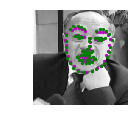

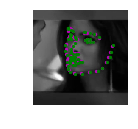

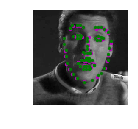

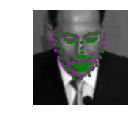

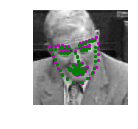

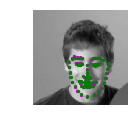

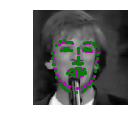

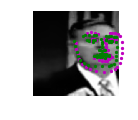

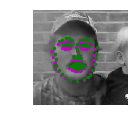

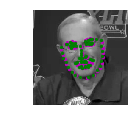

In [16]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [17]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_2.2.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:   
For Optimizer, two commonly used algorithms were tried, including Adam and SDG. Based on actual results, Adam performs better (converges more smoothly and drives lower loss) and hence is chosen.  
For Loss Function, since this is a regression problem, MSE and L1Loss etc measuring 'distance difference' makes sense. Based on actual results, MSE performs better and hence is chosen.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**:  
Following two network architectures were implemented and tested.
Net1 (Net1 class defined in models.py)
- Conv2D
- Relu
- Maxpooling
- Conv2D
- Relu
- Maxpooling
- Flatten
- Fully Connected
- Relu
- Dropout (p=0.4)
- Fully Connected

Net2 (Net1 class defined in models.py)
- Conv2D
- Relu
- Conv2D
- Relu
- Maxpooling
- Dropout (p=0.5)
- Conv2D
- Relu
- Conv2D
- Relu
- Maxpooling
- Dropout (p=0.5)
- Conv2D
- Relu
- Conv2D
- Relu
- Maxpooling
- Dropout (p=0.5)
- Flatten
- Fully Connected
- Relu
- Fully Connected

Dropout has been adopted in both network architectures to avoid overfitting. Net2 is much deeper and takes much longer time to train. But with GPU (in my case on my local environment), training time of 600 epocs for Net2 is still acceptable and it provides better result (from the test data visualization). So Net2 is adopted and final model is saved as "saved_models/keypoints_model_2.2.pt".

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:  
The hyperparameters I tuned for the project include epochs, batch_size and learning rate for optimizer. Following basic principles are followed:
- batch_size is constrained by RAM for either CPU or GPU. Typical values are 8, 16, 32, 64 and 128. Normally when combined with a good learning rate, model's validation and test accuracy should converge not too quickly and stablize over time (not indicated as overfitting with test data accruacy going up)
- typical values of learning rate to start with are 0.01, 0.001 and 0.0001. After finding the right range/scale, then start fine tuning at that scale.
- in general epochs can be increased as long as accuracy remains going upward yet without seeing the sign of overfitting.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.04892374  0.04866664 -0.2516205 ]
 [-0.31467855 -0.1648024  -0.05229002]
 [ 0.14126781 -0.34017652  0.2704137 ]]
(3, 3)


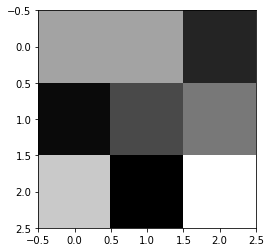

In [18]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

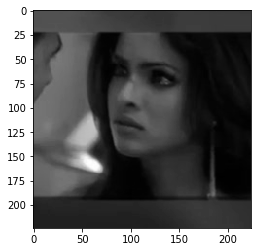

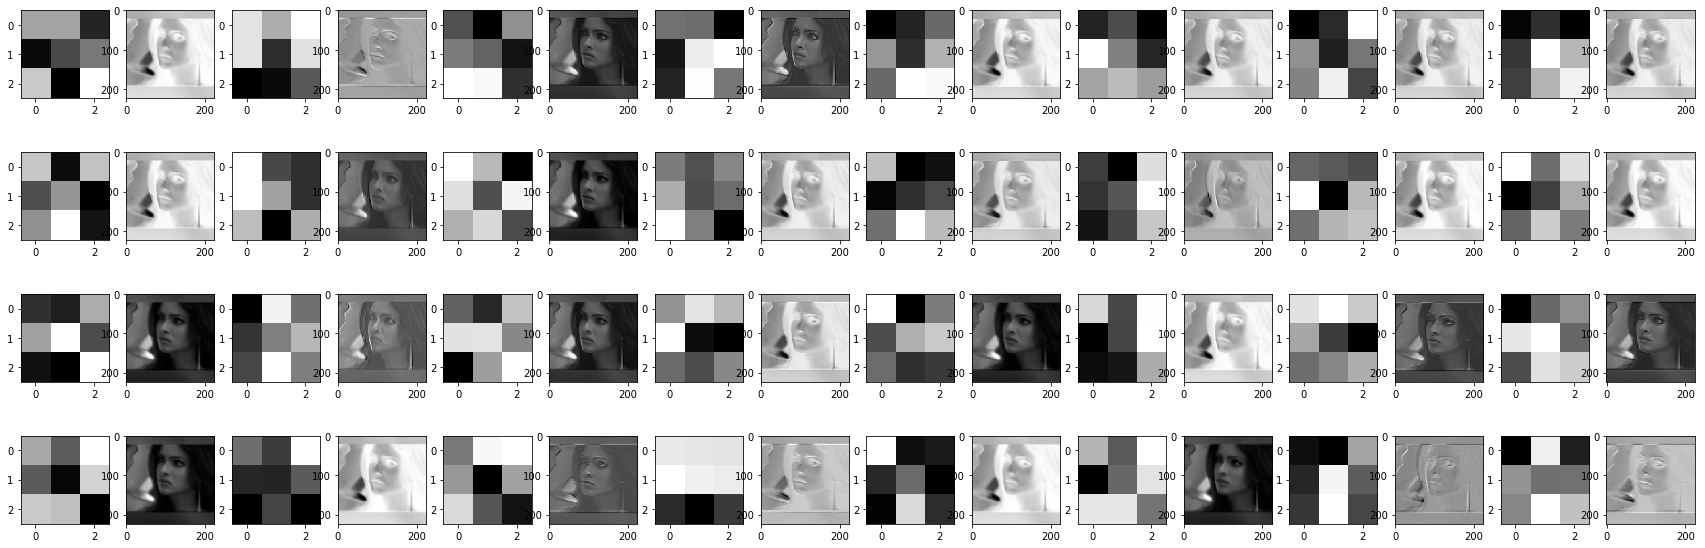

In [19]:
##TODO: load in and display any image from the transformed test dataset
idx = 1
image = test_images[idx].data
image = image.numpy()
img = np.squeeze(image)
plt.imshow(img, cmap='gray') ## showing test image

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2

## apply filters in conv1 to test image
weights = net.conv1.weight.data
w = weights.cpu().numpy()
fig=plt.figure(figsize=(30, 10))
columns = 8 * 2
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**:  
Above show various filters (total 32) in the first Convnet are being applied on the test image. Various filters have different purpose. As an example, the first filter on up left seems to take the reverse density of original image (i.e. dark becoming white and vice-versa) 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!